# ✍️ Text-to-Handwriting Generation
## Using Multi-Layer LSTM with Soft Window Attantion Mechanism  

This notebook covers **data preprocessing** and **model training** for generating handwriting from text.  

---

### 📌 **Overview:**  
- **Dataset:** IAM Online Handwriting Database (with additional transcript processing)
- **Model:** Multi-Layer LSTM with soft window attention mechanism  
- **Goal:** Convert text into handwritten strokes
  
---

### 📂 **Notebook Structure:**
1. **Data Loading and Visualization:** Parsing XML, Analysis and Visualization
2. **Dataset Preprocessing:** Remove Outliers, Normalization, Padding and Embedding
3. **Model Implementation:** Dataloader, LSTM with 3 layer and 1 window layer
4. **Training:** Optimizer, loss function, and hyperparameter tuning
5. **Inference & Visualization:** Generating and plotting handwriting strokes  

---

### 👨‍💻 **Author:**  
📝 **Muh. Buyung Saloka** — 5025231137  
📝 **Moh. Rizky Rahmadian Makkani** — 5025231035  
📝 **Naswan Nashir Ramadhan** — 5025231246  


📅 **Date:** April 2025  
🔗 **Project Repository:** -  

## Import Libraries 

In [1]:
import os
import glob
import html
import numpy as np
import pandas as pd
import math
import random
import time
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.distributions import bernoulli, uniform
from torch.optim.lr_scheduler import StepLR
from accelerate import Accelerator

## Data Loading and Visualization

### Read and Parse Data

In [2]:
# Get all XML files in current directory
dataset = '../data/labeled-lineStrokes'
xml_files = glob.glob(dataset + '/**/*.xml', recursive=True)
xml_files = sorted(xml_files)
print(f"Total XML files found: {len(xml_files)}")
print(f"First 3 files: {xml_files[:3]}")
print(f"Last 3 files: {xml_files[-3:]}")

Total XML files found: 10804
First 3 files: ['../data/labeled-lineStrokes/a01/a01-001/a01-001z-01-labeled.xml', '../data/labeled-lineStrokes/a01/a01-001/a01-001z-02-labeled.xml', '../data/labeled-lineStrokes/a01/a01-001/a01-001z-03-labeled.xml']
Last 3 files: ['../data/labeled-lineStrokes/r09/r09-711/r09-711z-05-labeled.xml', '../data/labeled-lineStrokes/r09/r09-711/r09-711z-06-labeled.xml', '../data/labeled-lineStrokes/r09/r09-711/r09-711z-07-labeled.xml']


In [3]:
# Function to parse an individual XML file
def parse_xml_file(file_path):
    try:
        tree = ET.parse(file_path)
    except Exception as e:
        print('Error parsing', file_path, e)
        return None
    root = tree.getroot()

    # Extract text information
    text_element = root.find('.//Text')
    text_val = text_element.text if text_element is not None else ""

    # Handle HTML entities
    if text_val:
        text_val = html.unescape(text_val)

    # Extract Writer ID
    writer_element = root.find('.//Writer')
    writer_id = int(writer_element.attrib.get('writerID', 0)) if writer_element is not None else ""

    # Extract strokes
    strokes = []
    stroke_elements = root.findall('.//Stroke')
    for stroke_element in stroke_elements:
        points = []
        point_elements = stroke_element.findall('.//Point')
        for point_element in point_elements:
            try:
                x = float(point_element.attrib.get('x', 0))
                y = float(point_element.attrib.get('y', 0))
                time = float(point_element.attrib.get('time', 0))
                points.append((x, y, time))
            except Exception as e:
                print('Error reading point in', file_path, e)
                continue
        if points:
            strokes.append(points)

    return {
        'file': file_path,
        'writer_id': writer_id,
        'text': text_val,
        'strokes': strokes
    }

In [4]:
# Parse all XML files
all_data = []
for file in tqdm(xml_files, desc="Parsing XML files", unit="file"):
    parsed = parse_xml_file(file)
    if parsed is not None:
        all_data.append(parsed)

print('Parsed', len(all_data), 'files.')

Parsing XML files: 100%|██████████| 10804/10804 [00:20<00:00, 515.78file/s]

Parsed 10804 files.


In [5]:
# Change stroke format from list(list(tuple)) to array(array) numpy
# Also remove time, and add one more dimension for boolean pen_status

converted_data = []
for data in tqdm(all_data, desc="Converting strokes"):
    stroke_points = []
    for stroke in data['strokes']:
        x_points, y_points, _ = zip(*stroke)
        pen_status = [0] * len(x_points)
        pen_status[-1] = 1  # Pen up after last point in stroke
        stroke_data = list(zip(pen_status, x_points, y_points))
        stroke_points.extend(stroke_data)

    stroke_points = np.array(stroke_points, dtype=np.float32)

    converted_data.append({
        'file': data['file'],
        'writer_id': data['writer_id'],
        'text': data['text'],
        'strokes': stroke_points
    })
all_data = converted_data

print('Converted data format.')

Converting strokes: 100%|██████████| 10804/10804 [00:02<00:00, 4929.13it/s]

Converted data format.


### Visualize Random Data

In [6]:
# Visualize the handwriting
def visualize_handwriting(strokes, invert_y=True):
    plt.figure(figsize=(12, 6))
    plt.title('Handwriting Visualization', fontsize=20, pad=15)
    plt.xlabel('X Coordinate', fontsize=16, labelpad=10)
    plt.ylabel('Y Coordinate', fontsize=16, labelpad=10)

    colors = ['#766CDB', '#DA847C', '#D9CC8B', '#7CD9A5', '#877877', '#52515E']

    xs, ys = [], []
    for i, point in enumerate(strokes):
        pen_status, x, y = point
        xs.append(x)
        ys.append(y)
        if pen_status == 1:  # Pen up
            plt.plot(xs, ys, color=colors[i % len(colors)], linewidth=2)
            xs, ys = [], []

    # Invert y-axis because in image coordinates, y increases downward
    if invert_y:
        plt.gca().invert_yaxis()

    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.7, color='#E0E0E0')
    plt.tight_layout()
    plt.show()

# Visualization with stroke order
def visualize_handwriting_with_order(strokes, invert_y=True):
    plt.figure(figsize=(12, 6))
    plt.title('Handwriting Stroke Order Visualization', fontsize=20, pad=15)
    plt.xlabel('X Coordinate', fontsize=16, labelpad=10)
    plt.ylabel('Y Coordinate', fontsize=16, labelpad=10)

    xs = [p[1] for p in strokes]
    ys = [p[2] for p in strokes]

    times = np.linspace(0, 1, len(xs))

    scatter = plt.scatter(xs, ys, c=times, cmap='viridis', s=5, alpha=0.8)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Normalized Stroke Order', fontsize=14)

    plt.plot(xs, ys, color='#766CDB', alpha=0.3, linewidth=2.5)

    if invert_y:
        plt.gca().invert_yaxis()

    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.7, color='#E0E0E0')
    plt.tight_layout()
    plt.show()

In [7]:
# Choose a random file to visualize
sample = random.choice(all_data)

print("File:", sample['file'])
print("Writer ID:", sample['writer_id'])
print("Text:", sample['text'])
print("Number of points:", len(sample['strokes']))

# Create a DataFrame from stroke points
df = pd.DataFrame(sample['strokes'], columns=['pen_status', 'x', 'y'])

stroke_ids = []
stroke_id = 0
for status in df['pen_status']:
    stroke_ids.append(stroke_id)
    if status == 1:
        stroke_id += 1

df['stroke_id'] = stroke_ids

print("Number of strokes:", stroke_id)

print("First few rows of the strokes DataFrame:")
print(df.head())

# Calculate some statistics per stroke
print("Statistics per stroke:")
stroke_stats = df.groupby('stroke_id').agg({
    'x': ['min', 'max', 'mean'],
    'y': ['min', 'max', 'mean']
})
stroke_stats.columns = ['x_min', 'x_max', 'x_mean', 'y_min', 'y_max', 'y_mean']
print(stroke_stats.head().to_string(index=True))

File: ../data/labeled-lineStrokes/j08/j08-421/j08-421z-02-labeled.xml
Writer ID: 10142
Text: at 110 v, was mounted above the
Number of points: 668
Number of strokes: 28
First few rows of the strokes DataFrame:
   pen_status      x       y  stroke_id
0         0.0  864.0  1269.0          0
1         0.0  865.0  1276.0          0
2         0.0  855.0  1275.0          0
3         0.0  844.0  1281.0          0
4         0.0  833.0  1298.0          0
Statistics per stroke:
            x_min   x_max       x_mean   y_min   y_max       y_mean
stroke_id                                                          
0           814.0   928.0   865.206909  1269.0  1440.0  1354.896606
1           973.0   991.0   982.352966  1237.0  1414.0  1343.294067
2           934.0  1015.0   985.125000  1322.0  1341.0  1329.500000
3          1229.0  1326.0  1288.319946  1209.0  1397.0  1310.479980
4          1370.0  1437.0  1407.280029  1194.0  1394.0  1281.520020


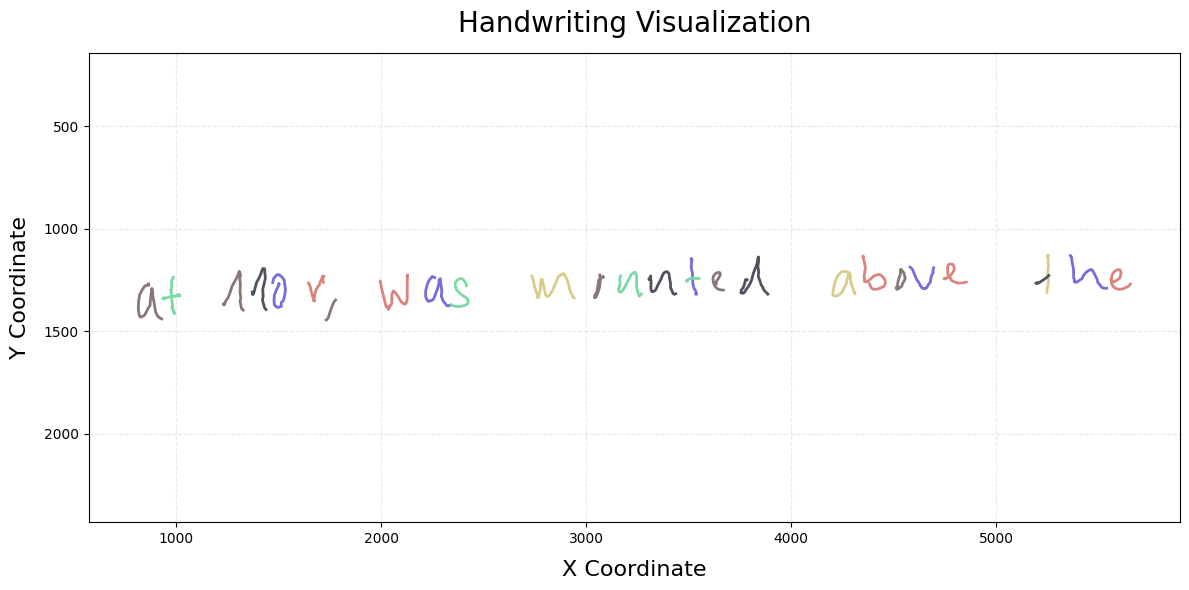

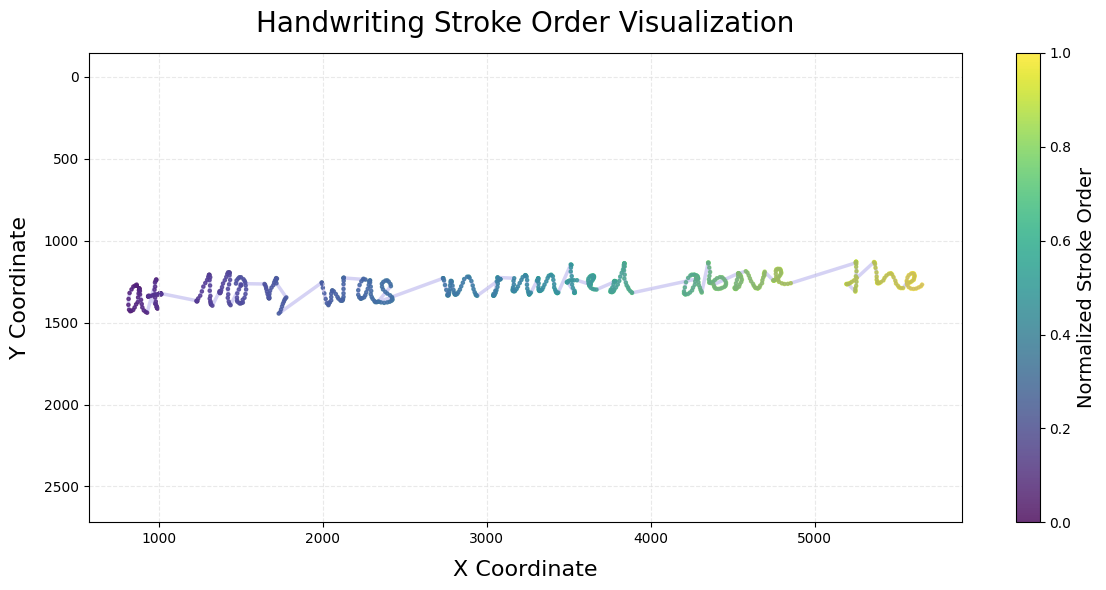

In [8]:
visualize_handwriting(sample['strokes'])
visualize_handwriting_with_order(sample['strokes'])

In [9]:
# Visualize subset data
def visualize_handwriting_subset(subset_stroke, invert_y=True):
    fig, axes = plt.subplots(3, 3, figsize=(15, 8))
    axes = axes.flatten()
    colors = ['#766CDB', '#DA847C', '#D9CC8B', '#7CD9A5', '#877877', '#52515E']

    for i in range(9):
        sample = subset_stroke[i]
        ax = axes[i]

        xs, ys = [], []
        for j, point in enumerate(sample['strokes']):
            pen_status, x, y = point
            xs.append(x)
            ys.append(y)
            if pen_status == 1:
                ax.plot(xs, ys, color=colors[j % len(colors)], linewidth=1.5)
                xs, ys = [], []

        if invert_y:
            ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(True)
        ax.axis('equal')

        ax.set_title(sample['text'], fontsize=10, pad=10)

    plt.tight_layout()
    plt.show()

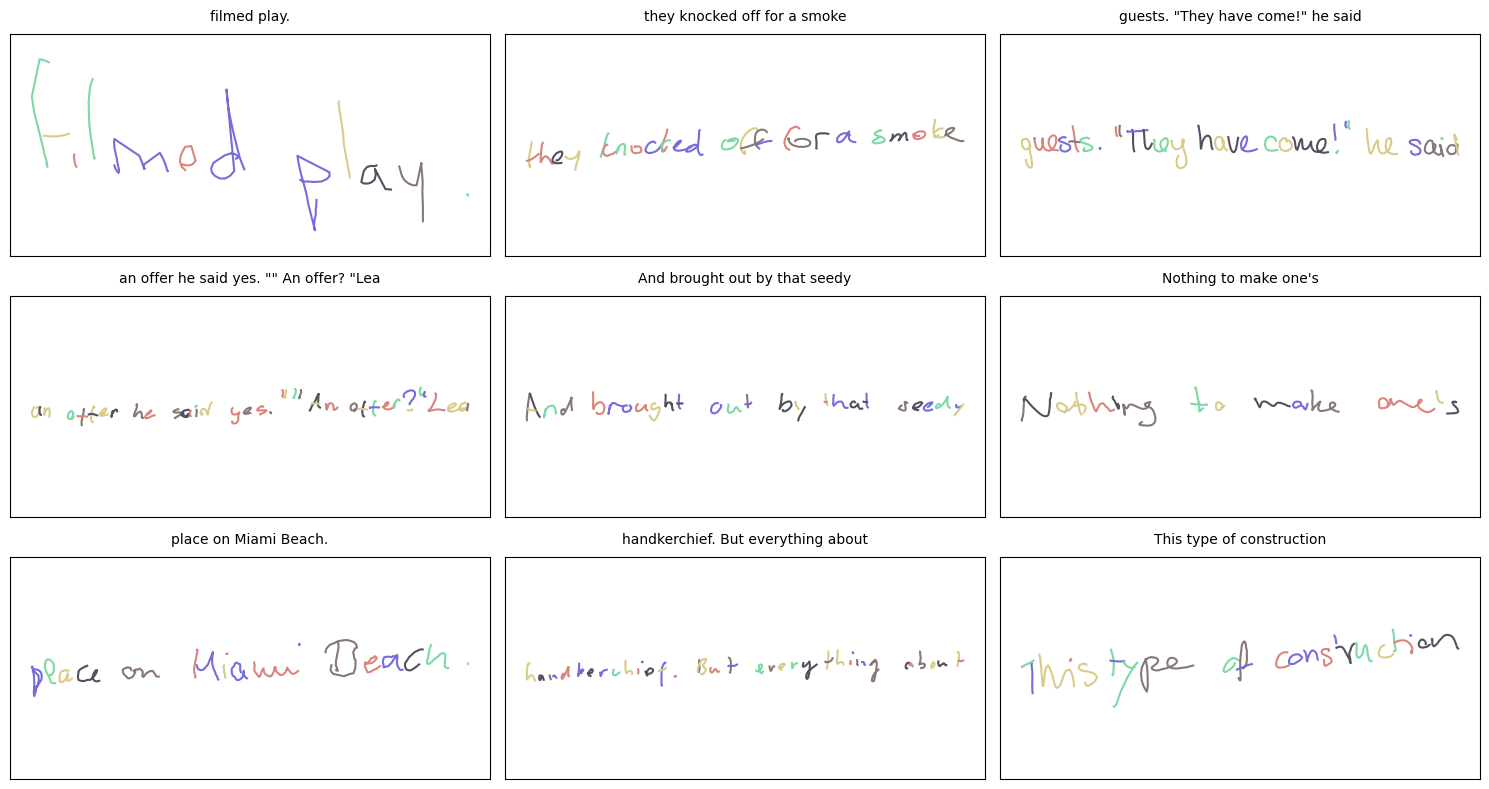

In [10]:
# Choose a random subset to visualization
subset_sample = all_data if len(all_data) <= 9 else random.sample(all_data, 9)
visualize_handwriting_subset(subset_sample)

### Data Analysis

#### Stroke and Text Length

Total strokes: 10804
Max length: 1940
Min length: 31
Mean length: 634.13
Median length: 626.00


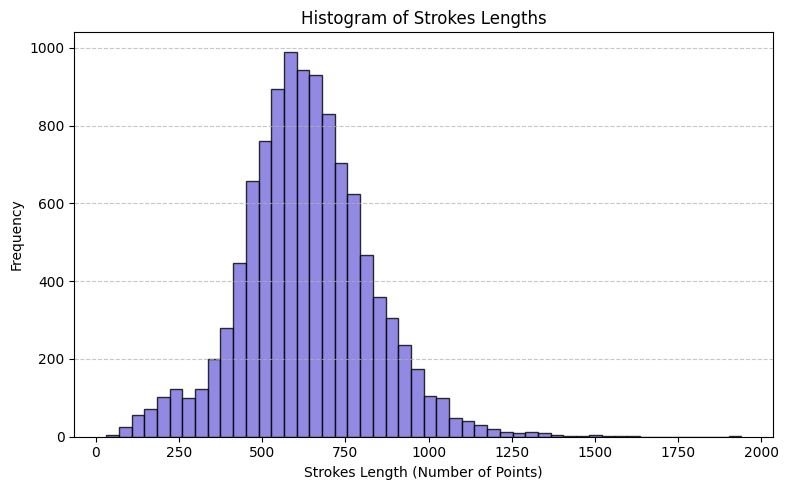

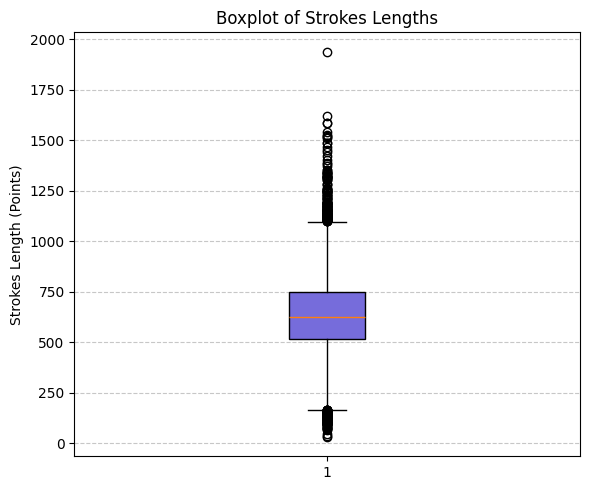

In [11]:
# Strokes Length in One Data Distribution
strokes_lengths = [len(data['strokes']) for data in all_data]

# Show some basic stats
print(f"Total strokes: {len(strokes_lengths)}")
print(f"Max length: {max(strokes_lengths)}")
print(f"Min length: {min(strokes_lengths)}")
print(f"Mean length: {np.mean(strokes_lengths):.2f}")
print(f"Median length: {np.median(strokes_lengths):.2f}")

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(strokes_lengths, bins=50, color='#766CDB', alpha=0.8, edgecolor='black')
plt.xlabel("Strokes Length (Number of Points)")
plt.ylabel("Frequency")
plt.title("Histogram of Strokes Lengths")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
plt.boxplot(strokes_lengths, vert=True, patch_artist=True,
            boxprops=dict(facecolor='#766CDB', color='black'))
plt.ylabel("Strokes Length (Points)")
plt.title("Boxplot of Strokes Lengths")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Total long strokes: 49


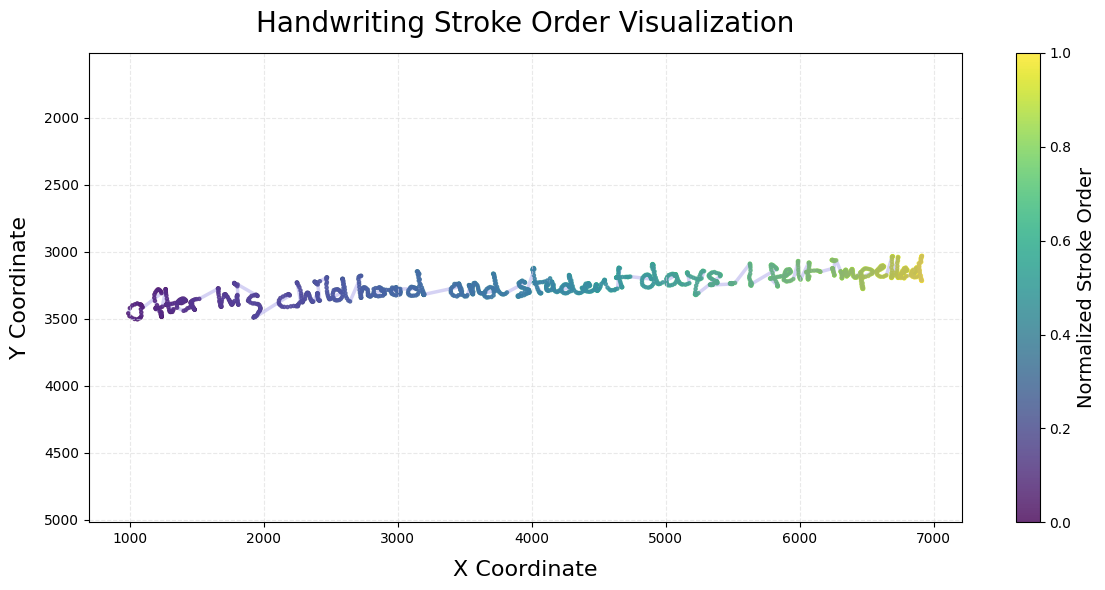

Text: after his childhood and student days. I felt impelled
Stroke Length: 1340


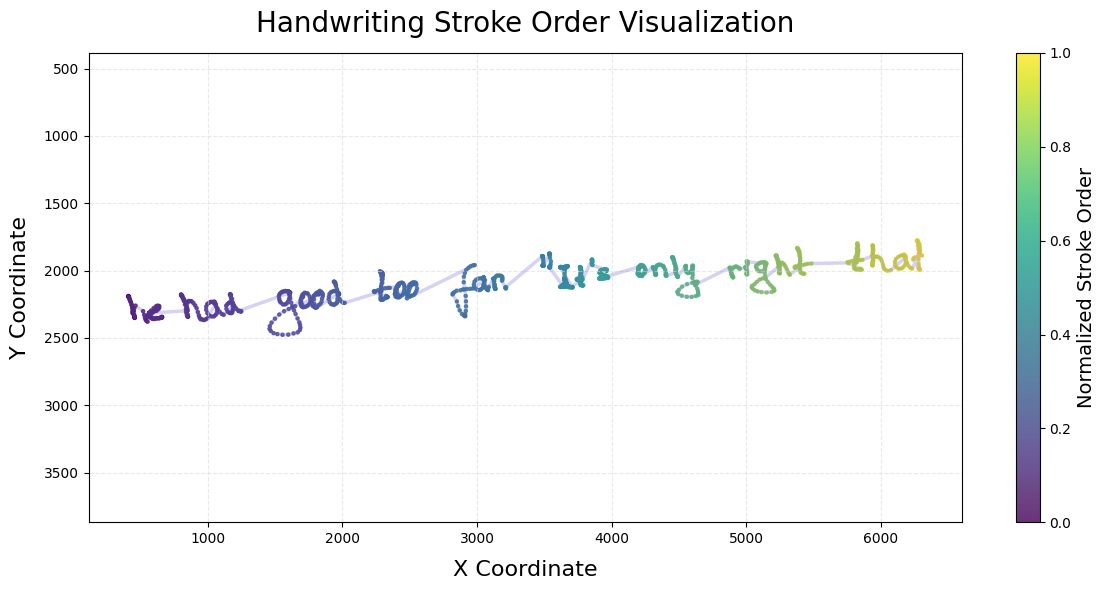

Text: he had gone too far. "It 's only right that
Stroke Length: 1254


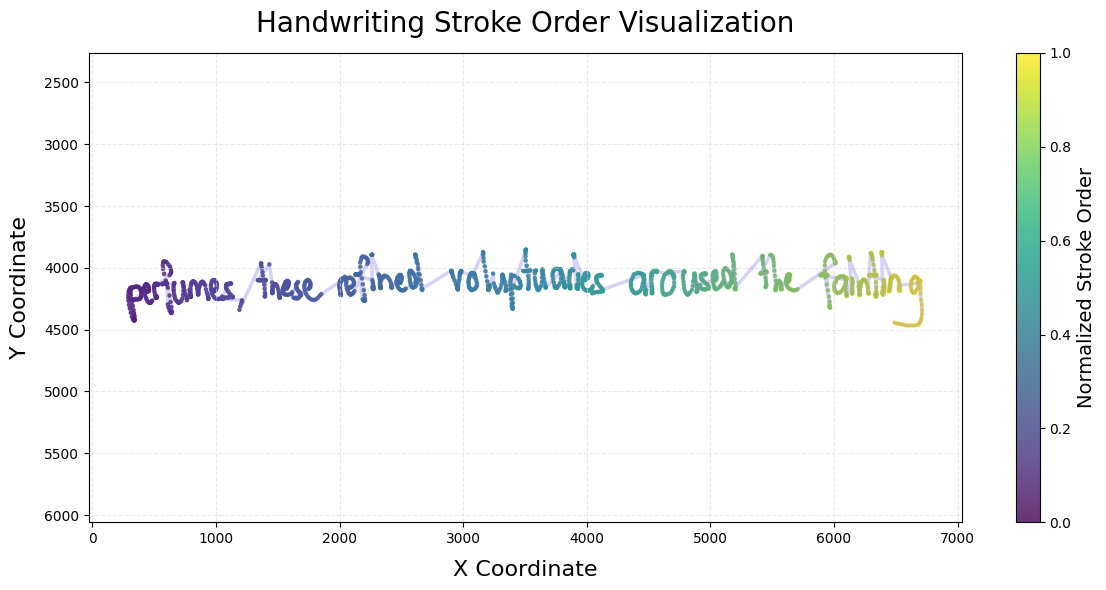

Text: perfumes, these refined voluptuaries aroused the fainting
Stroke Length: 1522


In [12]:
# Display data with strokes greater than threshold
long_strokes = [data for data in all_data if len(data['strokes']) > 1250 and len(data['text']) < 1300]
print(f"Total long strokes: {len(long_strokes)}")

# Visualize long strokes
sampled_data = random.sample(long_strokes, k=min(3, len(long_strokes)))
for i, data in enumerate(sampled_data):
    visualize_handwriting_with_order(data['strokes'])
    print(f"Text: {data['text']}")
    print(f"Stroke Length: {len(data['strokes'])}")

Total short strokes: 167


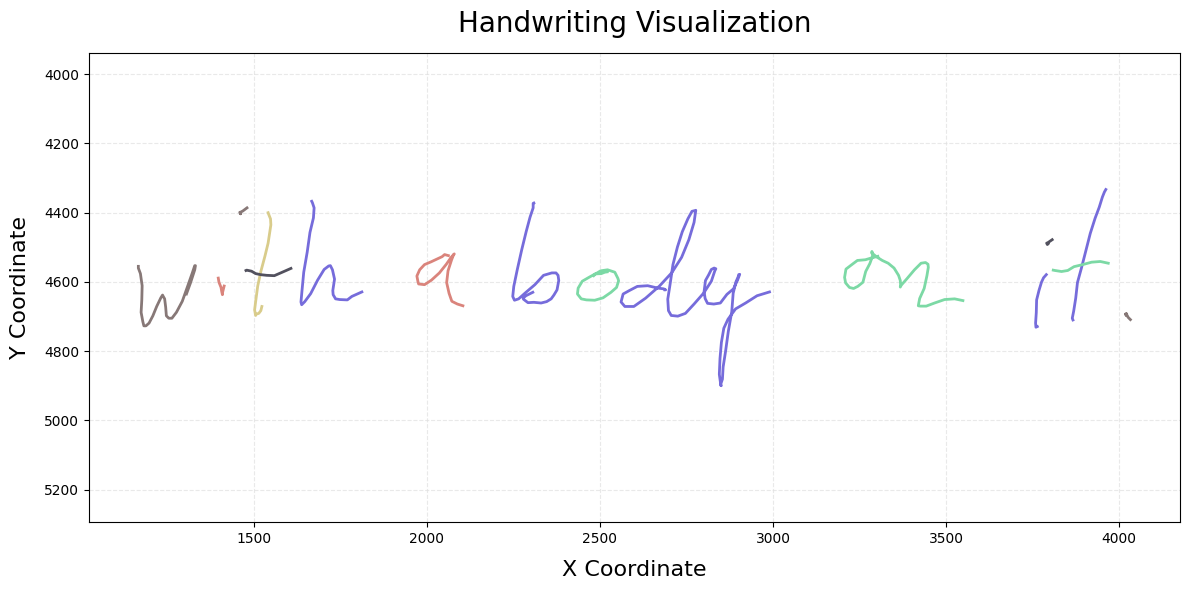

Text: with a body on it.
Stroke Length: 335


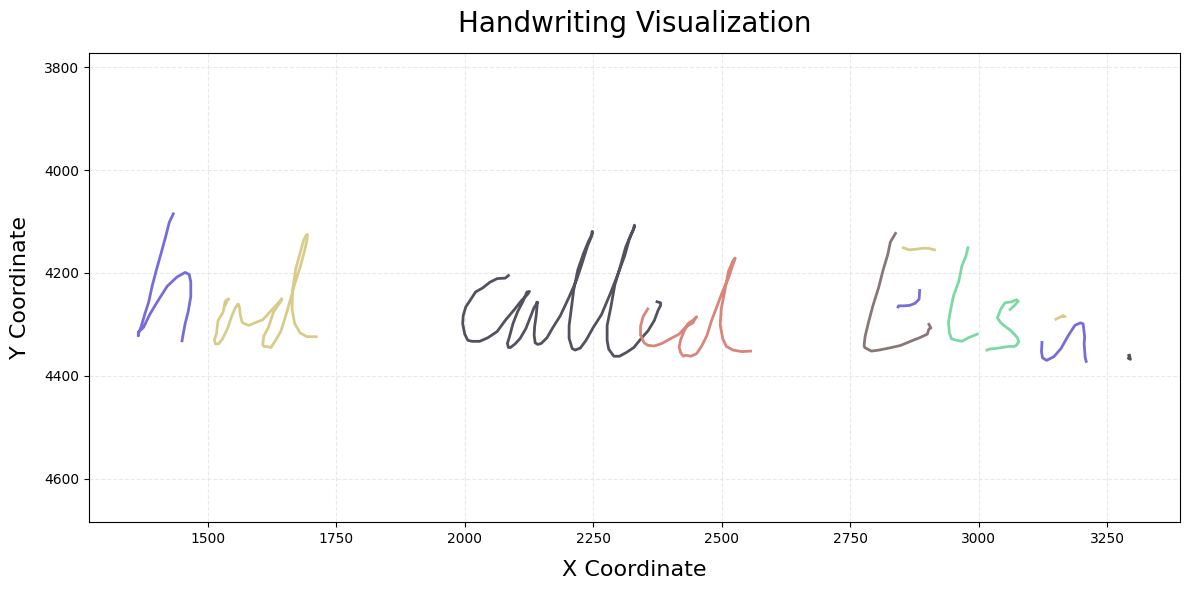

Text: had called Elsa.
Stroke Length: 318


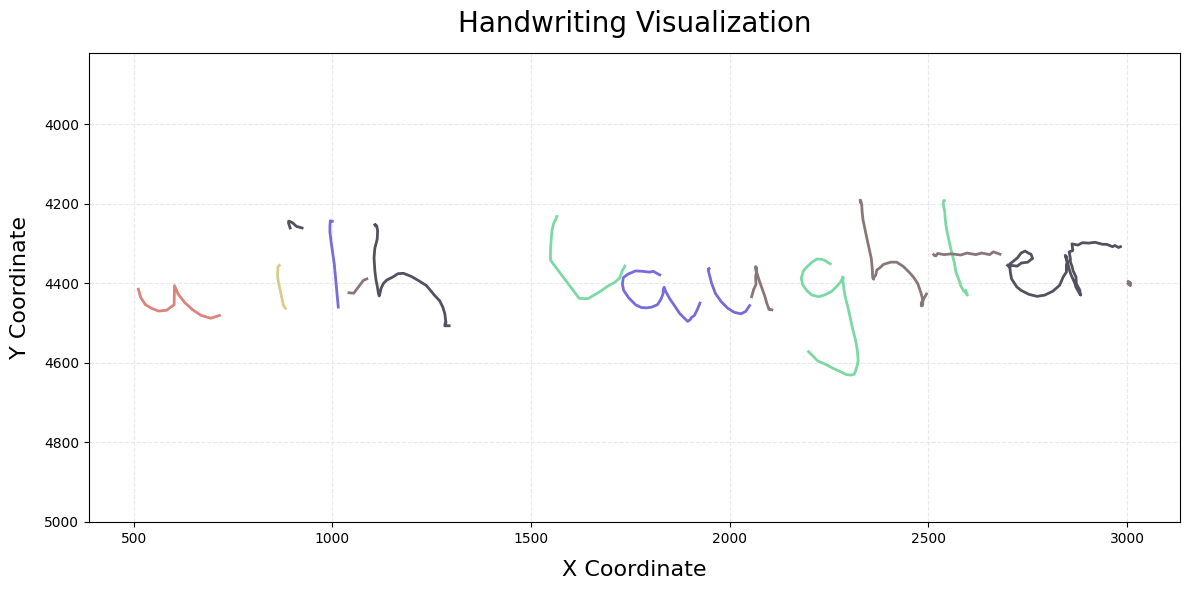

Text: with laughter.
Stroke Length: 341


In [13]:
# Display data with strokes less than threshold
short_strokes = [data for data in all_data if len(data['strokes']) < 350 and len(data['strokes']) > 300]
print(f"Total short strokes: {len(short_strokes)}")

# Visualize short strokes
sampled_data = random.sample(short_strokes, k=min(3, len(short_strokes)))
for i, data in enumerate(sampled_data):
    visualize_handwriting(data['strokes'])
    print(f"Text: {data['text']}")
    print(f"Stroke Length: {len(data['strokes'])}")

In [14]:
# Remove outliers
filtered_data = [data for data in all_data if 400 <= len(data['strokes']) <= 800]

print(f"Total data before filter: {len(all_data)}")
print(f"Total data after filter: {len(filtered_data)}")

Total data before filter: 10804
Total data after filter: 7971


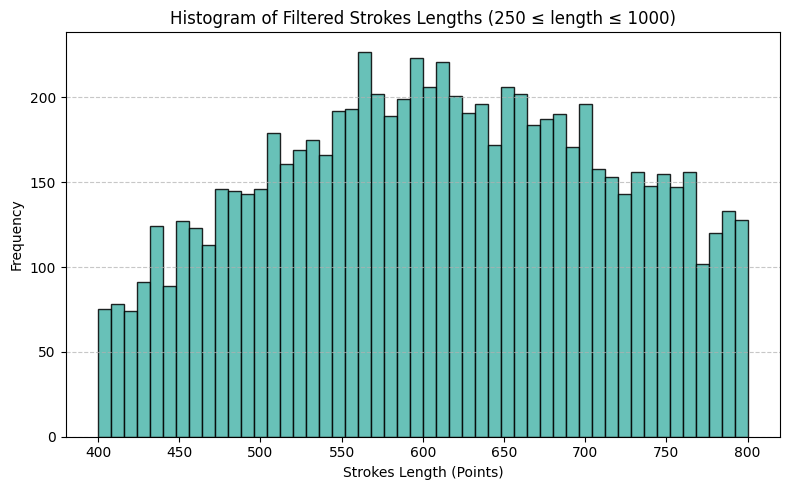

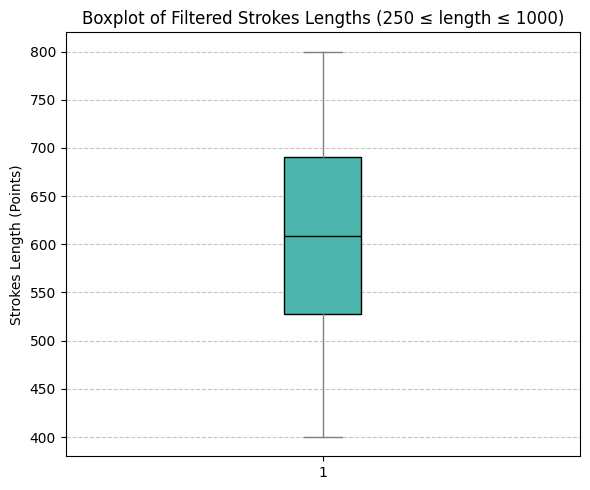

In [15]:
filtered_lengths = [len(data['strokes']) for data in filtered_data]

plt.figure(figsize=(8, 5))
plt.hist(filtered_lengths, bins=50, color='#4DB6AC', alpha=0.85, edgecolor='black')
plt.xlabel("Strokes Length (Points)")
plt.ylabel("Frequency")
plt.title("Histogram of Filtered Strokes Lengths (250 ≤ length ≤ 1000)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.boxplot(filtered_lengths, vert=True, patch_artist=True,
            boxprops=dict(facecolor='#4DB6AC', color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5, linestyle='none'))
plt.ylabel("Strokes Length (Points)")
plt.title("Boxplot of Filtered Strokes Lengths (250 ≤ length ≤ 1000)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
# Assign filtered_data to all_data
all_data = filtered_data
print("Successfully filtered data.")
print(f"All data length: {len(all_data)}")

Successfully filtered data.
All data length: 7971


Total samples: 7971
Max length: 60
Min length: 4
Average length: 25.26
Median length: 25.0


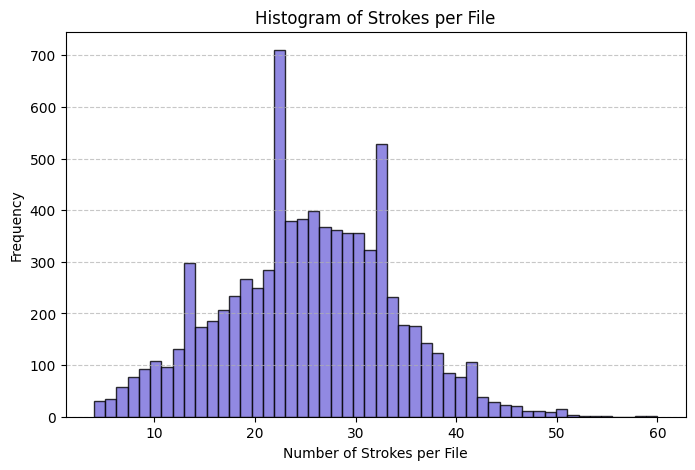

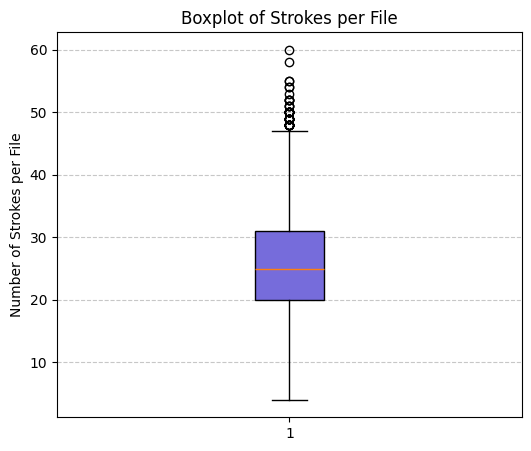

In [17]:
# Distribution of Strokes per File
files = [data["file"].split('/')[-1] for data in all_data]
n_strokes = [sum(1 for x in data["strokes"] if x[0] == 1) for data in all_data]

# Show some basic stats
print(f"Total samples: {len(n_strokes)}")
print(f"Max length: {max(n_strokes)}")
print(f"Min length: {min(n_strokes)}")
print(f"Average length: {np.mean(n_strokes):.2f}")
print(f"Median length: {np.median(n_strokes)}")

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(n_strokes, bins=50, color='#766CDB', alpha=0.8, edgecolor='black')
plt.xlabel("Number of Strokes per File")
plt.ylabel("Frequency")
plt.title("Histogram of Strokes per File")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
plt.boxplot(n_strokes, vert=True, patch_artist=True,
            boxprops=dict(facecolor='#766CDB', color='black'))
plt.ylabel("Number of Strokes per File")
plt.title("Boxplot of Strokes per File")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Total samples: 7971
Max length: 50
Min length: 8
Average length: 28.88
Median length: 29.0


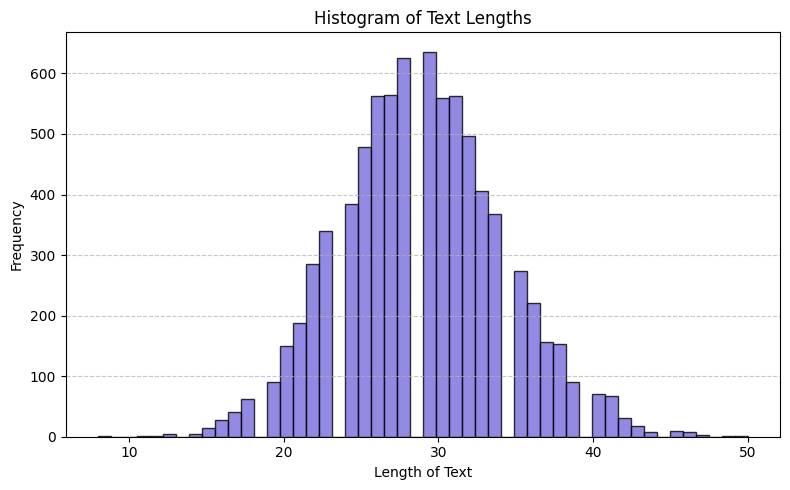

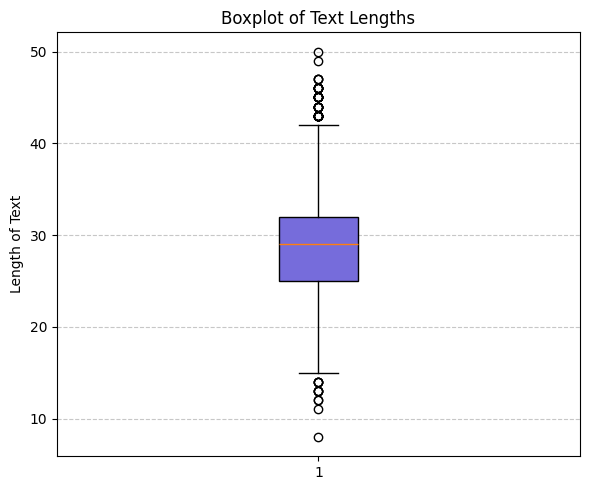

In [18]:
# Text Length Distribution
text_lengths = [len(data['text']) for data in all_data if isinstance(data['text'], str)]

# Show some basic stats
print(f"Total samples: {len(text_lengths)}")
print(f"Max length: {max(text_lengths)}")
print(f"Min length: {min(text_lengths)}")
print(f"Average length: {np.mean(text_lengths):.2f}")
print(f"Median length: {np.median(text_lengths)}")

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(text_lengths, bins=50, color='#766CDB', alpha=0.8, edgecolor='black')
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.title("Histogram of Text Lengths")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(6, 5))
plt.boxplot(text_lengths, vert=True, patch_artist=True,
            boxprops=dict(facecolor='#766CDB', color='black'))
plt.ylabel("Length of Text")
plt.title("Boxplot of Text Lengths")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Noise Points

#### Using Distance Beetwen Two Points

In [19]:
def compute_max_distance_per_stroke(data_list):
    result = []

    for data in tqdm(data_list, desc="Scanning distances"):
        strokes = data['strokes']
        points = strokes[:, 1:3]

        if len(points) < 2:
            max_dist = 0.0
        else:
            distances = np.linalg.norm(points[1:] - points[:-1], axis=1)
            max_dist = np.max(distances)

        result.append((max_dist, strokes))

    return result

Scanning distances: 100%|██████████| 7971/7971 [00:00<00:00, 48531.40it/s]


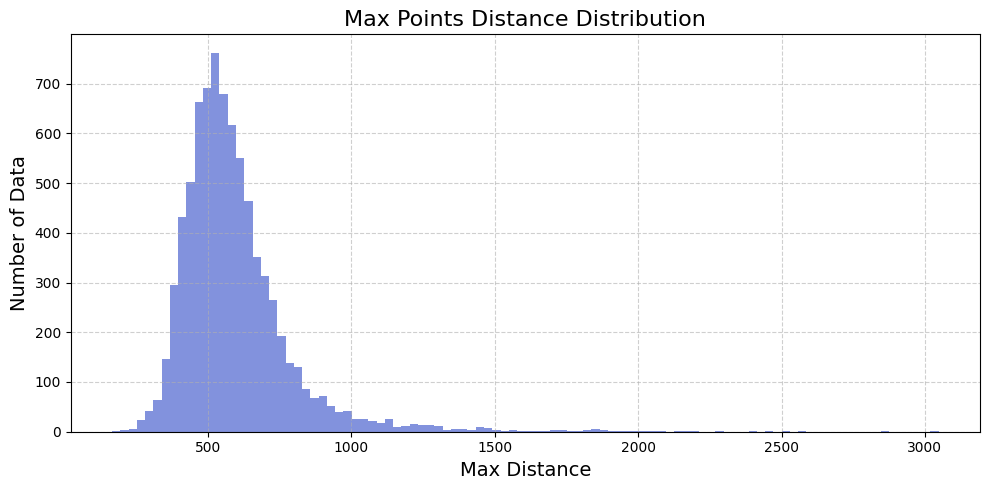

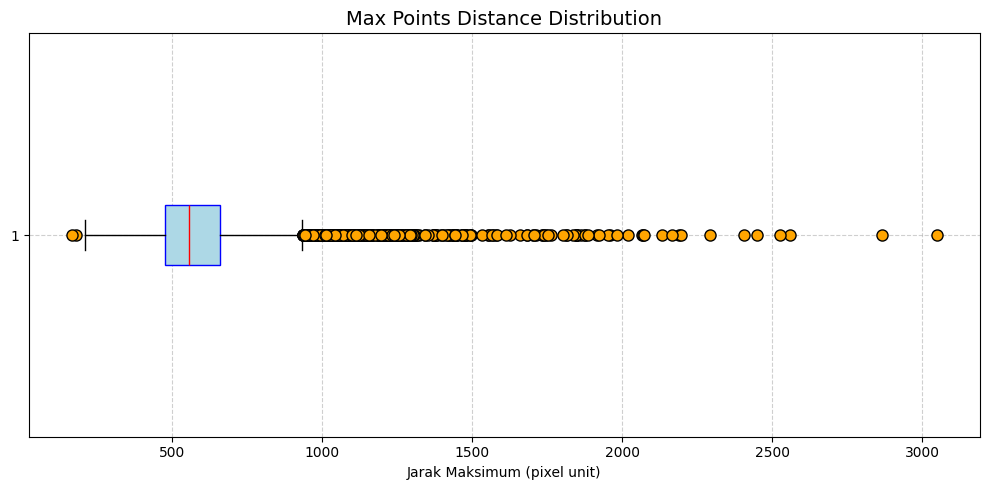

In [20]:
strokes_with_max_dist = compute_max_distance_per_stroke(all_data)

# Histogram
plt.figure(figsize=(10, 5))
plt.hist([dist[0] for dist in strokes_with_max_dist], bins=100, color='#6C7FD7', alpha=0.85)
plt.title("Max Points Distance Distribution", fontsize=16)
plt.xlabel("Max Distance", fontsize=14)
plt.ylabel("Number of Data", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
plt.boxplot([dist[0] for dist in strokes_with_max_dist], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            flierprops=dict(marker='o', markerfacecolor='orange', markersize=8, linestyle='none'))

plt.title("Max Points Distance Distribution", fontsize=14)
plt.xlabel("Jarak Maksimum (pixel unit)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Max distance: 1215.2880859375


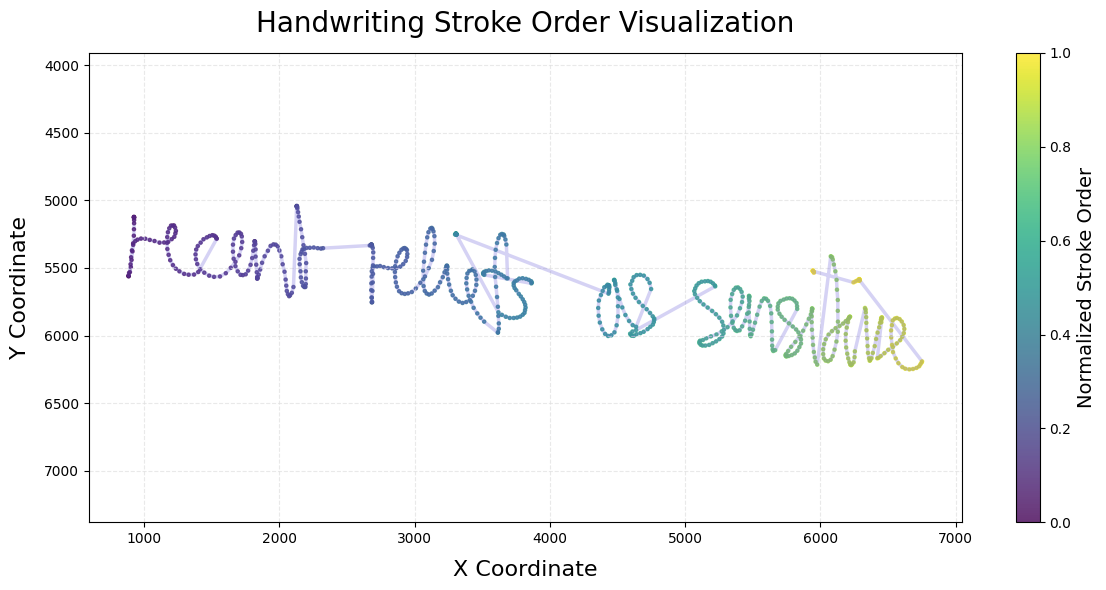

In [21]:
# visualize data with max distance

max_dist_data = [data for data in strokes_with_max_dist if data[0] > 1200 and data[0] < 1300]
max_dist = random.choice(max_dist_data)
if max_dist_data:
    print(f"Max distance: {max_dist[0]}")
    visualize_handwriting_with_order(max_dist[1])

#### Using Absolute Position

In [22]:
def detect_all_positional_outliers(data_list, threshold=3.0):
    outlier_counts = []
    outlier_masks = []

    for data in tqdm(data_list, desc="Detecting outliers"):
        strokes = data['strokes']
        points = strokes[:, 1:3]

        # Median & MAD based z-score
        median = np.median(points, axis=0)
        mad = np.median(np.abs(points - median), axis=0) + 1e-6
        z_scores = np.abs((points - median) / mad)
        is_outlier = np.any(z_scores > threshold, axis=1)

        outlier_masks.append(is_outlier)
        outlier_counts.append(np.sum(is_outlier))

    indices_sorted = np.argsort(outlier_counts)[::-1]

    return outlier_counts, outlier_masks, indices_sorted

In [23]:
def visualize_handwriting_with_outliers(strokes, outlier_mask):
    plt.figure(figsize=(12, 6))
    plt.title('Handwriting with Outliers Highlighted', fontsize=20)
    plt.xlabel('X')
    plt.ylabel('Y')

    strokes = np.array(strokes)
    xs, ys = strokes[:, 1], strokes[:, 2]

    # Normal points
    plt.scatter(xs[~outlier_mask], ys[~outlier_mask], s=10, color='blue', label='Normal')
    # Outliers
    plt.scatter(xs[outlier_mask], ys[outlier_mask], s=30, color='red', label='Outliers')

    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Detecting outliers: 100%|██████████| 7971/7971 [00:00<00:00, 13093.56it/s]


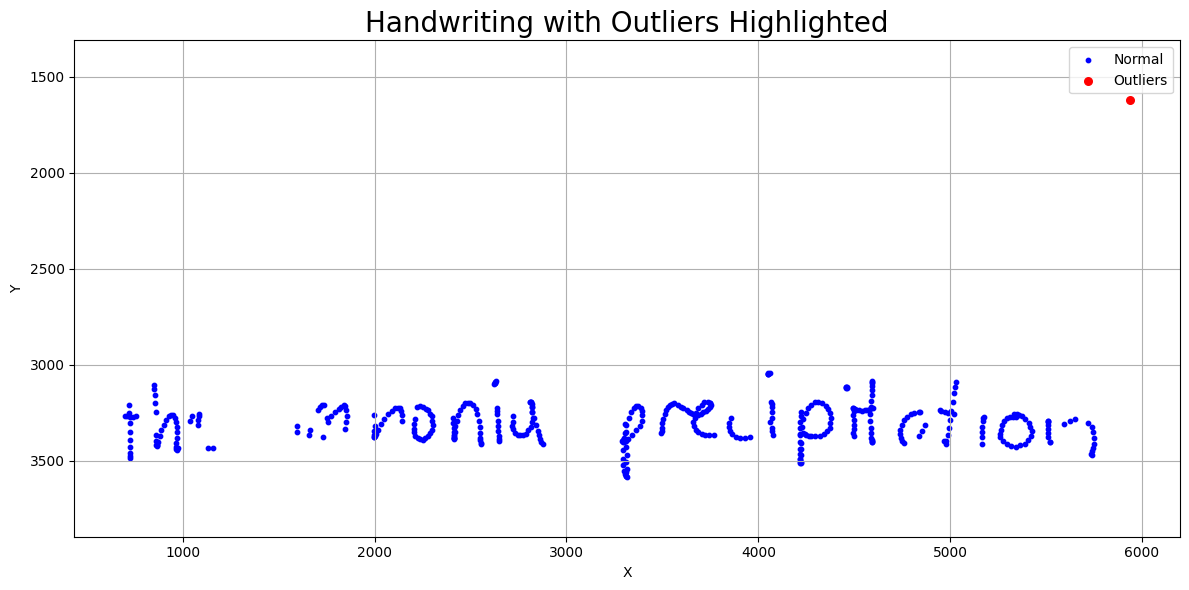

File: ../data/labeled-lineStrokes/j01/j01-048/j01-048z-04-labeled.xml | Outliers: 1
Text: the ammonia precipitation


In [24]:
# Detect outlier
outlier_counts, outlier_masks, indices_sorted = detect_all_positional_outliers(all_data, threshold=16.5)

for i in range(10):
    idx = indices_sorted[i]
    strokes = all_data[idx]['strokes']
    mask = outlier_masks[idx]
    if outlier_counts[idx] > 0:
        visualize_handwriting_with_outliers(strokes, mask)
        print(f"File: {all_data[idx]['file']} | Outliers: {outlier_counts[idx]}")
        print(f"Text: {all_data[idx]['text']}")

In [25]:
# Remove outliers in one data
def remove_outliers_in_data(data, outlier_mask):
    strokes = data['strokes']
    cleaned_strokes = strokes[~outlier_mask]
    return {
        'file': data['file'],
        'text': data['text'],
        'strokes': cleaned_strokes
    }

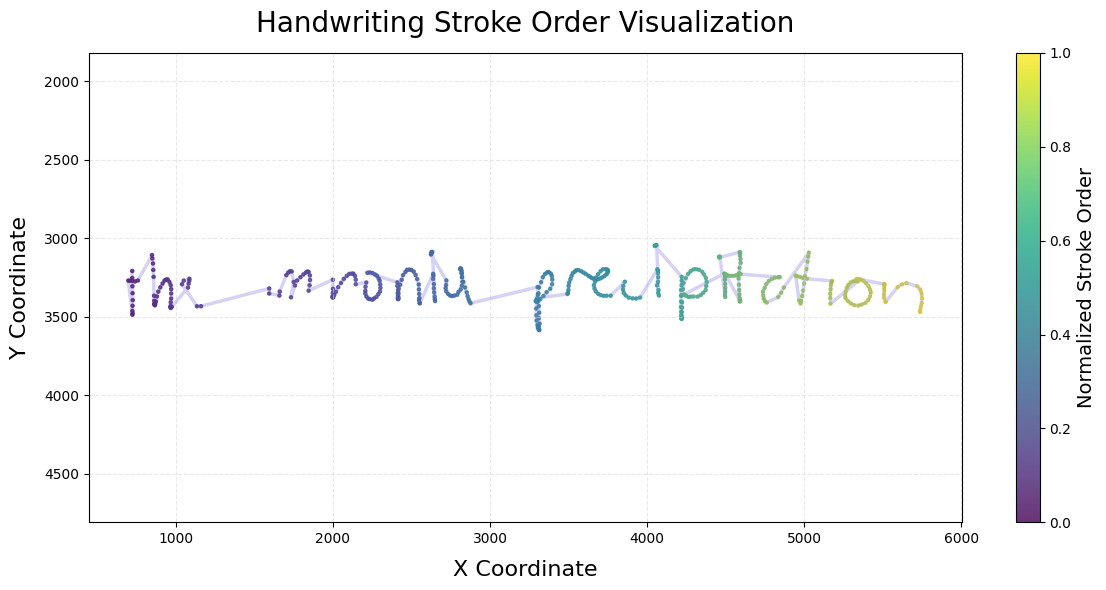

File: ../data/labeled-lineStrokes/j01/j01-048/j01-048z-04-labeled.xml
Text: the ammonia precipitation


In [26]:
# Remove outliers only on data with file name path/to/j01/j01-048/j01-048z-04-labeled.xml
outlier_file = '../data/labeled-lineStrokes/j01/j01-048/j01-048z-04-labeled.xml'
outlier_index = next((i for i, data in enumerate(all_data) if data['file'] == outlier_file), None)

if outlier_index is not None:
    outlier_mask = outlier_masks[outlier_index]
    cleaned_data = remove_outliers_in_data(all_data[outlier_index], outlier_mask)
    visualize_handwriting_with_order(cleaned_data['strokes'])
    print(f"File: {cleaned_data['file']}")
    print(f"Text: {cleaned_data['text']}")

In [27]:
all_data[outlier_index]['strokes'] = cleaned_data['strokes']
print(f"Outliers removed from {outlier_file}.")

Outliers removed from ../data/labeled-lineStrokes/j01/j01-048/j01-048z-04-labeled.xml.


### Words and Characters

In [28]:
# Frequency of Words and Characters
word_counter = Counter()
for data in all_data:
    words = data['text'].split()
    word_counter.update(words)

char_counter = Counter()
for data in all_data:
  char_counter.update(data['text'])

non_alpha_counter = Counter()
for data in all_data:
    non_alpha_chars = [char for char in data['text'] if not char.isalpha()]
    non_alpha_counter.update(non_alpha_chars)

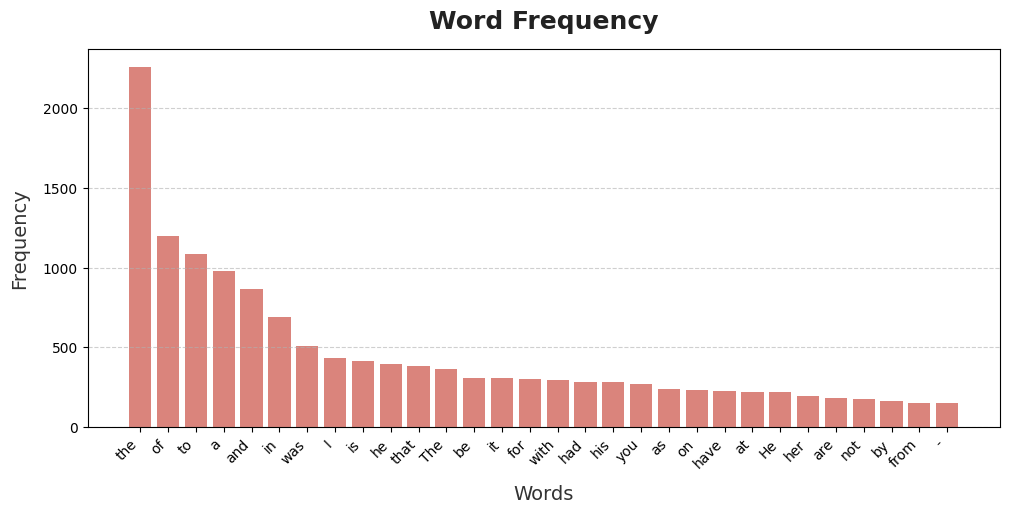

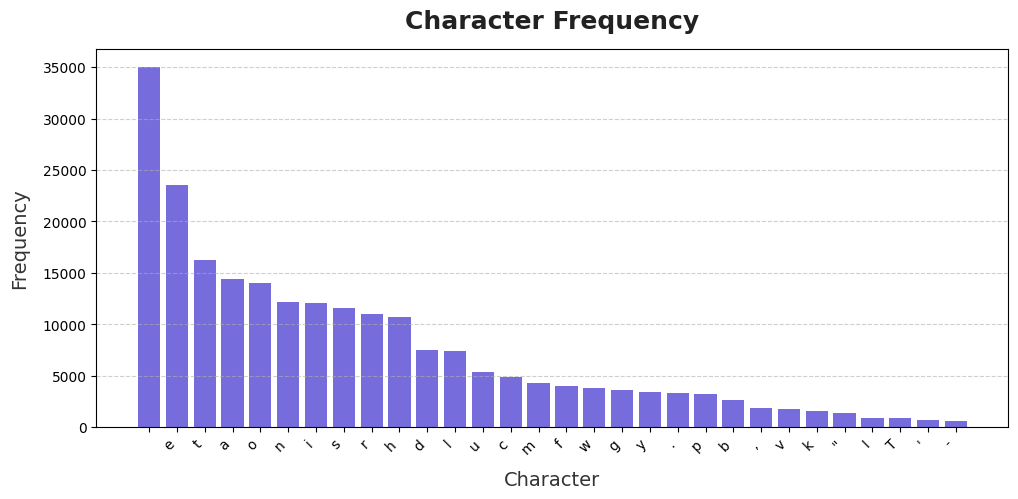

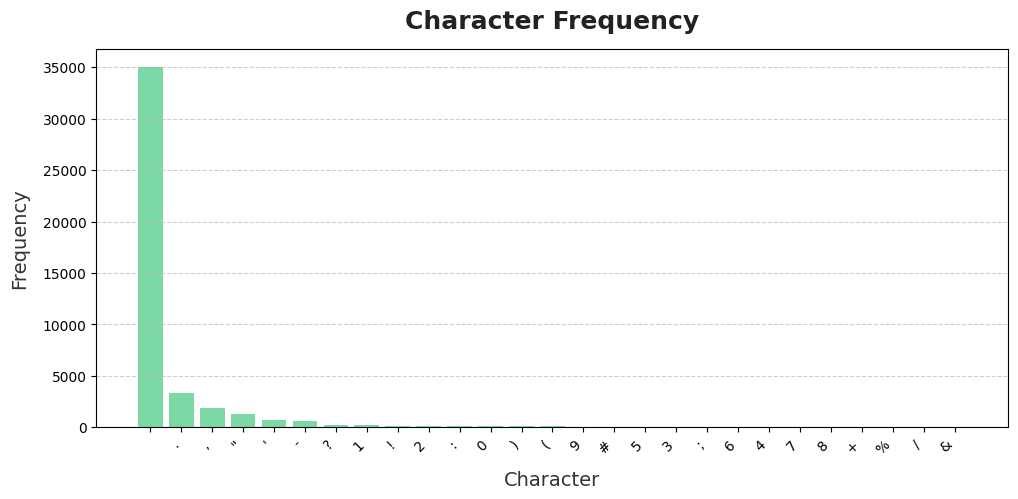

In [29]:
# Bar Chart

# Word Frequency
words, frequencies = zip(*word_counter.most_common())
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.25)
ax.bar(words[:30], frequencies[:30], color='#DA847C')
ax.set_title('Word Frequency', pad=15, fontsize=18, fontweight='semibold', color='#222222')
ax.set_xlabel('Words', labelpad=10, fontsize=14, fontweight='medium', color='#333333')
ax.set_ylabel('Frequency', labelpad=10, fontsize=14, fontweight='medium', color='#333333')
ax.set_xticks(range(len(words[:30])))
ax.set_xticklabels(words[:30], rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Character Frequency
chars, frequencies = zip(*char_counter.most_common())
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.25)
ax.bar(chars[:30], frequencies[:30], color='#766CDB')
ax.set_title('Character Frequency', pad=15, fontsize=18, fontweight='semibold', color='#222222')
ax.set_xlabel('Character', labelpad=10, fontsize=14, fontweight='medium', color='#333333')
ax.set_ylabel('Frequency', labelpad=10, fontsize=14, fontweight='medium', color='#333333')
ax.set_xticks(range(len(chars[:30])))
ax.set_xticklabels(chars[:30], rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Non Alpha Character Frequency
non_alpha_chars, frequencies = zip(*non_alpha_counter.most_common())
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.25)
ax.bar(non_alpha_chars[:30], frequencies[:30], color='#7CD9A5')
ax.set_title('Character Frequency', pad=15, fontsize=18, fontweight='semibold', color='#222222')
ax.set_xlabel('Character', labelpad=10, fontsize=14, fontweight='medium', color='#333333')
ax.set_ylabel('Frequency', labelpad=10, fontsize=14, fontweight='medium', color='#333333')
ax.set_xticks(range(len(non_alpha_chars[:30])))
ax.set_xticklabels(non_alpha_chars[:30], rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

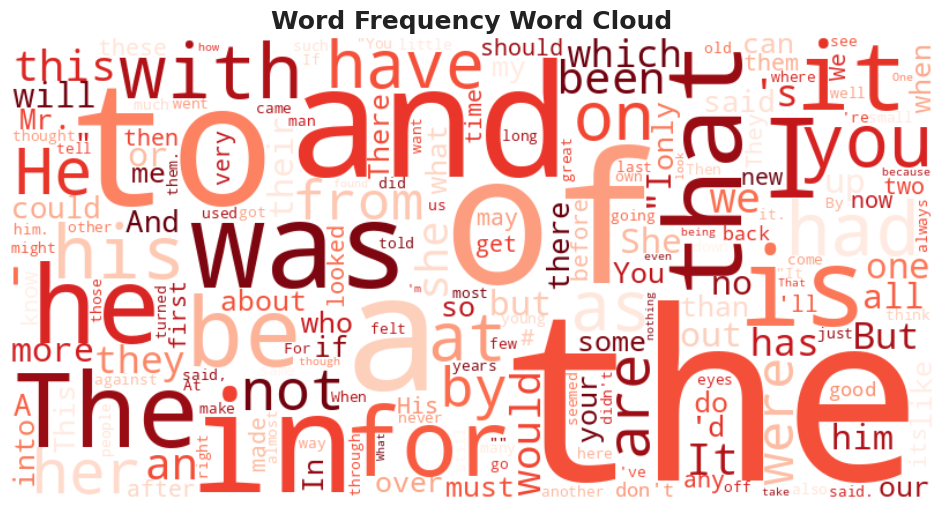

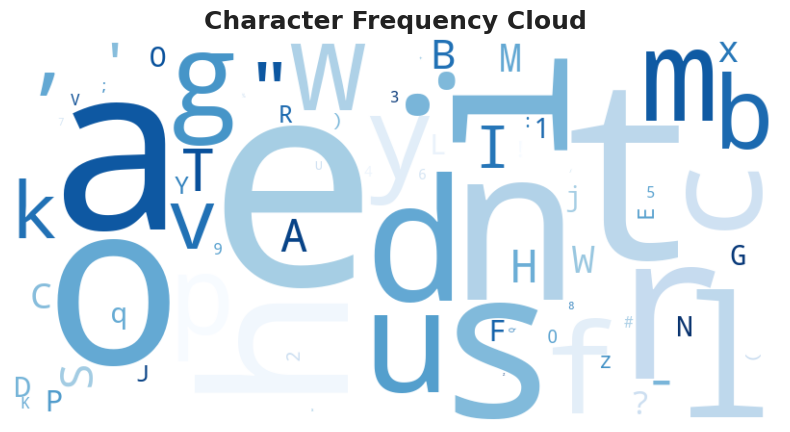

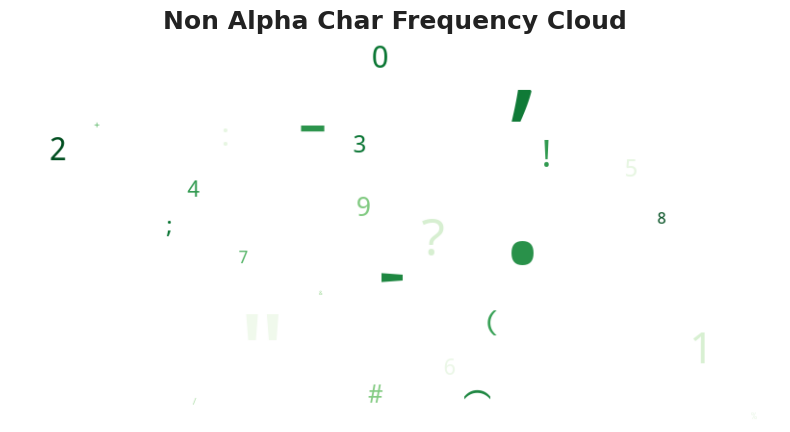

In [30]:
# Word Cloud

# Words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds')
wordcloud.generate_from_frequencies(word_counter)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Frequency Word Cloud", fontsize=18, fontweight='semibold', color='#222222')
plt.show()

# Characters
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues')
wordcloud.generate_from_frequencies(char_counter)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Character Frequency Cloud", fontsize=18, fontweight='semibold', color='#222222')
plt.show()

# Non Alpha Characters
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens')
wordcloud.generate_from_frequencies(non_alpha_counter)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Non Alpha Char Frequency Cloud", fontsize=18, fontweight='semibold', color='#222222')
plt.show()

### Group Data By Writer

In [31]:
grouped_by_writer = defaultdict(list)

for data in all_data:
    writer_id = data['writer_id']
    grouped_by_writer[writer_id].append(data)

print(f"Num of Unique Writer: {len(grouped_by_writer)}")


Num of Unique Writer: 195


Writer ID: 10107
Num of data write by this writer: 52


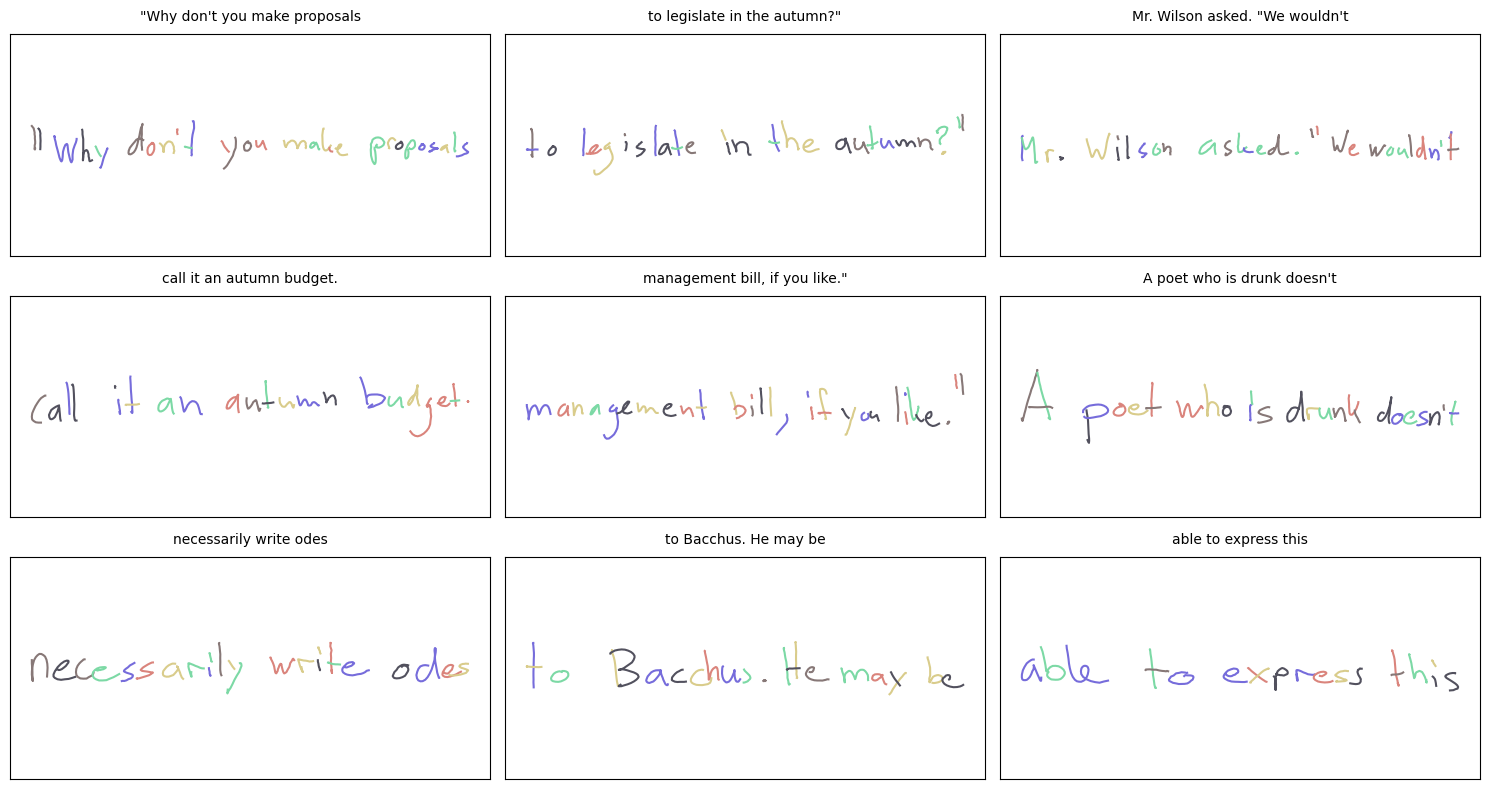

In [32]:
# randomize writer and sample 9 data from same writer
writer_ids = list(grouped_by_writer.keys())
random.shuffle(writer_ids)
subset_writer = []
for writer_id in writer_ids:
    subset_writer.extend(grouped_by_writer[writer_id])
    if len(subset_writer) >= 9:
        break

print("Writer ID:", subset_writer[0]['writer_id'])
print("Num of data write by this writer:", len(subset_writer))
visualize_handwriting_subset(subset_writer[:9])



## Preprocessing

### Strokes Data Normalization

In [33]:
# Normalize stroke from absolute position to delta position
norm_factor = 20
all_normalized_data = []

for data in tqdm(all_data, desc="Processing Files", unit="file"):
    strokes = data['strokes']

    xy = strokes[:, 1:3]
    pen_status = strokes[1:, 0]

    delta_xy = xy[1:] - xy[:-1]
    delta_xy /= norm_factor  # Normalize

    normalized_strokes = np.hstack((pen_status.reshape(-1, 1), delta_xy))

    # Invert Y
    normalized_strokes[:, 2] = -normalized_strokes[:, 2]

    normalized_strokes = np.vstack(([0, 0, 0], normalized_strokes))

    all_normalized_data.append({
        'file': data['file'],
        'text': data['text'],
        'strokes': normalized_strokes
    })

print('Normalized data format.')

Processing Files: 100%|██████████| 7971/7971 [00:00<00:00, 26646.75file/s]

Normalized data format.


In [34]:
# Check is strokes normalized correctly
print("Before normalized:")
print(all_data[0])
print(len(all_data[0]['strokes']))

print("After normalized:")
print(all_normalized_data[0])
print(len(all_normalized_data[0]['strokes']))

Before normalized:
{'file': '../data/labeled-lineStrokes/a01/a01-001/a01-001z-02-labeled.xml', 'writer_id': 10028, 'text': 'to stop Mr. Gaitskell from', 'strokes': array([[0.000e+00, 8.450e+02, 2.344e+03],
       [0.000e+00, 8.360e+02, 2.347e+03],
       [0.000e+00, 8.340e+02, 2.363e+03],
       ...,
       [0.000e+00, 6.076e+03, 2.864e+03],
       [0.000e+00, 6.075e+03, 2.864e+03],
       [1.000e+00, 6.079e+03, 2.866e+03]], dtype=float32)}
780
After normalized:
{'file': '../data/labeled-lineStrokes/a01/a01-001/a01-001z-02-labeled.xml', 'text': 'to stop Mr. Gaitskell from', 'strokes': array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.44999999, -0.15000001],
       [ 0.        , -0.1       , -0.80000001],
       ...,
       [ 0.        ,  0.69999999, -0.44999999],
       [ 0.        , -0.05      , -0.        ],
       [ 1.        ,  0.2       , -0.1       ]])}
780


### Visualize Normalized Data

In [35]:
def delta_to_absolute(strokes):
    abs_coords = []
    x, y = 0, 0
    for pen_status, dx, dy in strokes:
        x += dx
        y += dy
        abs_coords.append((pen_status, x, y))
    return np.array(abs_coords)

File: ../data/labeled-lineStrokes/j01/j01-026/j01-026z-05-labeled.xml
Text: lime and thoria doped with rare earth oxides.
Strokes: [[ 0.          0.          0.        ]
 [ 0.         -0.05       -0.        ]
 [ 0.          0.         -0.34999999]
 [ 0.         -0.1        -0.60000002]
 [ 0.         -0.2        -1.45000005]]


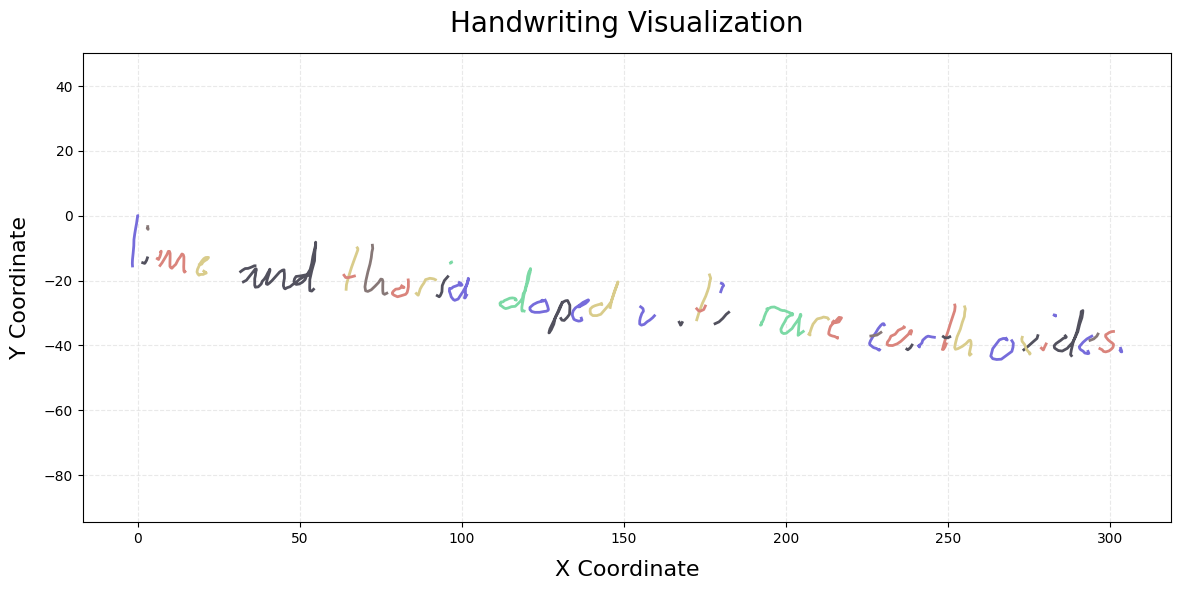

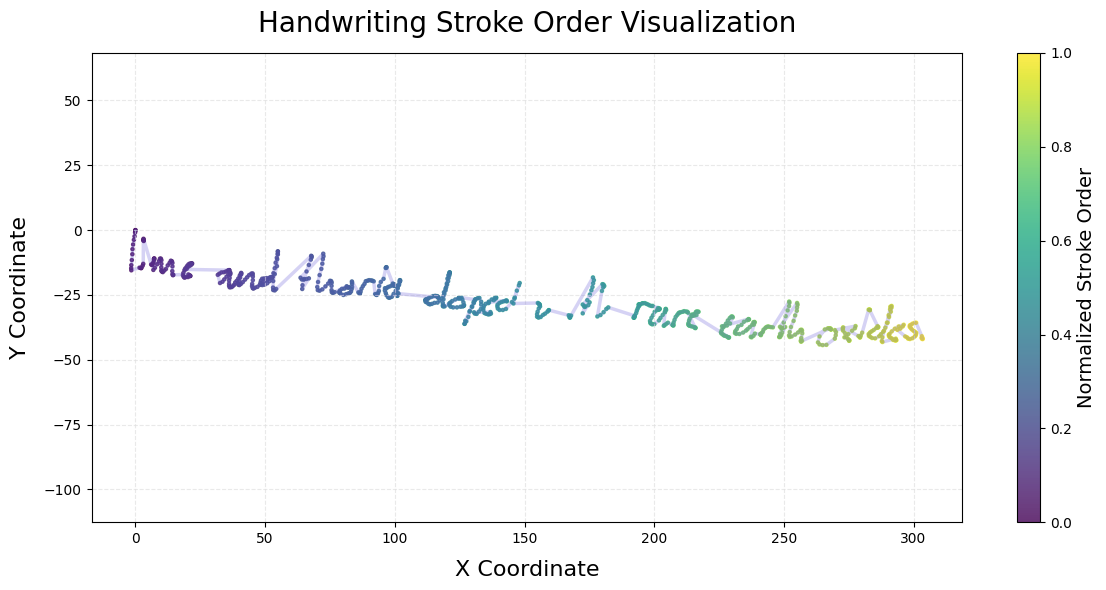

In [36]:
# Choose a random file to visualize
normalized_sample = random.choice(all_normalized_data)

print("File:", normalized_sample['file'])
print("Text:", normalized_sample['text'])
print("Strokes:", normalized_sample['strokes'][:5])

visualize_handwriting(delta_to_absolute(normalized_sample['strokes']), invert_y=False)
visualize_handwriting_with_order(delta_to_absolute(normalized_sample['strokes']), invert_y=False)

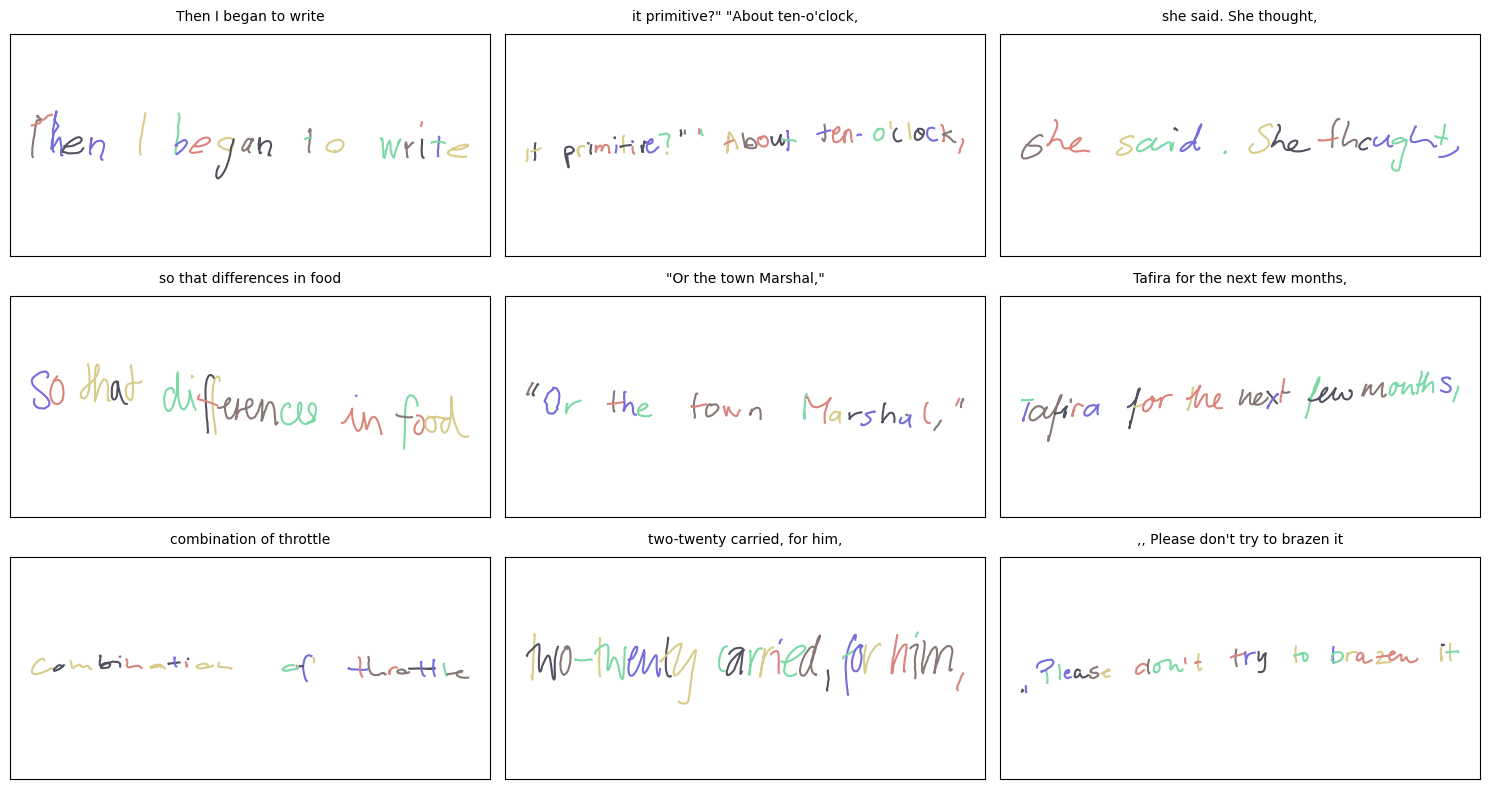

In [37]:
# Choose a random subset to visualization
normalized_subset_sample = all_normalized_data if len(all_normalized_data) <= 9 else random.sample(all_normalized_data, 9)
abs_subset_sample_stroke = [delta_to_absolute(data['strokes']) for data in normalized_subset_sample]

normalized_subset_sample = [{'file': data['file'], 'text': data['text'], 'strokes': stroke} for data, stroke in zip(normalized_subset_sample, abs_subset_sample_stroke)]

visualize_handwriting_subset(normalized_subset_sample, invert_y=False)

### Padding Strokes

In [38]:
def pad_strokes(strokes_list):
    # Find length and max length
    lengths = [s.shape[0] for s in strokes_list]
    max_length = np.max(lengths)
    num_strokes = len(strokes_list)

    # Create mask
    mask_shape = (num_strokes, max_length)
    mask = np.zeros(mask_shape, dtype=np.float32)

    # Pad strokes
    padded_shape = (num_strokes, max_length, 3)
    padded = np.zeros(padded_shape, dtype=np.float32)
    for i, length in enumerate(lengths):
        padded[i, :length] = strokes_list[i]
        mask[i, :length] = 1.

    return padded, mask

In [39]:
all_normalized_strokes = [data['strokes'] for data in all_normalized_data]
strokes_list = [torch.tensor(s, dtype=torch.float32) for s in all_normalized_strokes]
padded_strokes, stroke_masks = pad_strokes(strokes_list)

print(f"Strokes Padded Shape: {padded_strokes.shape}")
print(f"Strokes Mask Shape: {stroke_masks.shape}")

Strokes Padded Shape: (7971, 800, 3)
Strokes Mask Shape: (7971, 800)


### Character Embedding

In [41]:
def pad_encoded_texts(char_sequences):
    # Find length and max length
    lengths = [t.shape[0] for t in char_sequences]
    max_length = np.max(lengths)
    num_char = len(char_sequences)

    # Create mask
    mask_shape = (num_char, max_length)
    mask = np.zeros(mask_shape, dtype=np.float32)

    # Pad texts
    padded = np.full((num_char, max_length), ' ', dtype='<U1')
    for i, length in enumerate(lengths):
        padded[i, :length] = char_sequences[i]
        mask[i, :length] = 1.

    return padded, mask

In [42]:
# Collect all unique characters
all_texts = [data['text'] for data in all_normalized_data]
unique_chars = set("".join(all_texts))
unique_chars = sorted(unique_chars)

vocab_size = len(unique_chars)

print(f"Unique characters: {unique_chars}")
print(f"Vocabulary size: {vocab_size}")

Unique characters: [' ', '!', '"', '#', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary size: 79


In [43]:
# Character to Index Mapping
char_to_index = {char: idx for idx, char in enumerate(unique_chars)}
index_to_char = {idx: char for char, idx in char_to_index.items()}

def chars_to_sequence(chars):
    return np.array([char_to_index.get(char) for char in chars], dtype=np.float32)

def sequence_to_chars(indices):
    return np.array([index_to_char.get(int(idx)) for idx in indices], dtype='<U1')

In [44]:
texts_list = [data['text'] for data in all_data]
char_sequences = np.array([np.array(list(text), dtype='<U1') for text in texts_list], dtype=object)
padded_texts, text_masks = pad_encoded_texts(char_sequences)

print("Padded Texts Shape:", padded_texts.shape)
print("Text Mask Shape:", text_masks.shape)

Padded Texts Shape: (7971, 50)
Text Mask Shape: (7971, 50)


In [45]:
# Test decode sequence
example_seq = padded_texts[0]
example_mask = text_masks[0]

# Decode seq back to text
decoded_text = "".join(
    char for char, m in zip(example_seq, example_mask) if m > 0
)

print(f"Example Sequence: {example_seq}")
print(f"Mask: {example_mask}")
print(f"Decoded Text: {decoded_text}")

Example Sequence: ['t' 'o' ' ' 's' 't' 'o' 'p' ' ' 'M' 'r' '.' ' ' 'G' 'a' 'i' 't' 's' 'k'
 'e' 'l' 'l' ' ' 'f' 'r' 'o' 'm' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
 ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
Mask: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Decoded Text: to stop Mr. Gaitskell from


## Model Implementation

### Dataloader

In [46]:
# Data utils
class Global:
    train_mean = 0.0
    train_std = 1.0

def train_offset_normalization(data):
    mean = data[:, :, 1:].mean(axis=(0, 1))
    data[:, :, 1:] -= mean
    std = data[:, :, 1:].std(axis=(0, 1))
    data[:, :, 1:] /= std
    return mean, std, data


def valid_offset_normalization(mean, std, data):
    data[:, :, 1:] -= mean
    data[:, :, 1:] /= std
    return data

def data_denormalization(mean, std, data):
    data[:, :, 1:] *= std
    data[:, :, 1:] += mean
    return data

def data_normalization(data):
    mean = data[:, 1:].mean(axis=0)
    data[:, 1:] -= mean
    std = data[:, 1:].std(axis=0)
    data[:, 1:] /= std
    return mean, std, data

In [47]:
class HandwritingDataset(Dataset):
    def __init__(self, padded_strokes, stroke_masks, padded_texts, text_masks, split='train', debug=False):
        """
        Args:
            padded_strokes (np.ndarray): (N, max_seq_len, 3), containing stroke data (pen_status, x, y).
            stroke_masks (np.ndarray): (N, max_seq_len), indicating valid stroke points (1: valid, 0: padding).
            padded_texts (np.ndarray): (N, max_text_len), containing padded character sequences (dtype='<U1').
            text_masks (np.ndarray): (N, max_text_len), indicating valid characters (1: valid, 0: padding).
            split (str): Either 'train' or 'valid', determines the dataset split.
            debug (bool): If True, loads a small subset of the data.
        """

        assert padded_strokes.shape[0] == padded_texts.shape[0], "Strokes and Texts has different length"
        assert padded_strokes.shape[0] == stroke_masks.shape[0], "Strokes and stroke masks have different length"
        assert padded_texts.shape[0] == text_masks.shape[0], "Texts and text masks have different length"

        # Shuffle and split
        n_total = padded_strokes.shape[0]
        idx_permute = np.random.permutation(n_total)

        padded_strokes = padded_strokes[idx_permute]
        stroke_masks = stroke_masks[idx_permute]

        padded_texts = padded_texts[idx_permute]
        text_masks = text_masks[idx_permute]

        if debug:
            debug_data_size = 1300
            padded_strokes = padded_strokes[:debug_data_size]
            stroke_masks = stroke_masks[:debug_data_size]
            padded_texts = padded_texts[:debug_data_size]
            text_masks = text_masks[:debug_data_size]

        n_train = int(0.9 * padded_strokes.shape[0])

        self._data = padded_strokes
        if split == 'train':
            self.dataset = padded_strokes[:n_train]
            self.mask = stroke_masks[:n_train]
            self.texts = padded_texts[:n_train]
            self.text_masks = text_masks[:n_train]
            Global.train_mean, Global.train_std, self.dataset = train_offset_normalization(self.dataset)
        else:
            self.dataset = padded_strokes[n_train:]
            self.mask = stroke_masks[n_train:]
            self.texts = padded_texts[n_train:]
            self.text_masks = text_masks[n_train:]
            self.dataset = valid_offset_normalization(Global.train_mean, Global.train_std, self.dataset)

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        stroke_mask = torch.from_numpy(self.mask[idx])

        input_seq = torch.zeros(self.dataset[idx].shape, dtype=torch.float32)
        input_seq[1:, :] = torch.from_numpy(self.dataset[idx, :-1, :])

        target_seq = torch.from_numpy(self.dataset[idx])
        text = torch.from_numpy(chars_to_sequence(self.texts[idx]))
        text_mask = torch.from_numpy(self.text_masks[idx])
        return (input_seq, target_seq, stroke_mask, text, text_mask)

In [48]:
torch.manual_seed(2025)
np.random.seed(2025)
batch_size = 64
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize dataset
train_dataset = HandwritingDataset(
    padded_strokes, stroke_masks,
    padded_texts, text_masks,
    split='train', debug=False
)

valid_dataset = HandwritingDataset(
    padded_strokes, stroke_masks,
    padded_texts, text_masks,
    split='valid', debug=False
)

# Initializze dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

In [49]:
# Test DataLoader
print("Train Loader")
for batch in train_loader:
    input_seq, target_seq, stroke_mask, text, text_mask = batch
    print("Input Sequence shape:", input_seq.shape)       # (batch_size, seq_len, 3)
    print("Target shape:", target_seq.shape)              # (batch_size, seq_len, 3)
    print("Stroke Mask shape:", stroke_mask.shape)        # (batch_size, seq_len)
    print("Text shape:", text.shape)                      # (batch_size, text_len)
    print("Text Mask shape:", text_mask.shape)            # (batch_size, text_len)
    break

print("\nValid Loader")
for batch in valid_loader:
    input_seq, target_seq, stroke_mask, text, text_mask = batch
    print("Input Sequence shape:", input_seq.shape)       # (batch_size, seq_len, 3)
    print("Target shape:", target_seq.shape)              # (batch_size, seq_len, 3)
    print("Stroke Mask shape:", stroke_mask.shape)        # (batch_size, seq_len)
    print("Text shape:", text.shape)                      # (batch_size, text_len)
    print("Text Mask shape:", text_mask.shape)            # (batch_size, text_len)
    break

Train Loader
Input Sequence shape: torch.Size([64, 800, 3])
Target shape: torch.Size([64, 800, 3])
Stroke Mask shape: torch.Size([64, 800])
Text shape: torch.Size([64, 50])
Text Mask shape: torch.Size([64, 50])

Valid Loader
Input Sequence shape: torch.Size([64, 800, 3])
Target shape: torch.Size([64, 800, 3])
Stroke Mask shape: torch.Size([64, 800])
Text shape: torch.Size([64, 50])
Text Mask shape: torch.Size([64, 50])


### LSTM Handwriting Model

In [50]:
def stable_softmax(X, dim=2):
    max_vec = torch.max(X, dim, keepdim=True)
    exp_X = torch.exp(X - max_vec[0])
    sum_exp_X = torch.sum(exp_X, dim, keepdim=True)
    X_hat = exp_X / sum_exp_X
    return X_hat

In [51]:
def sample_from_out_dist(y_hat, bias):
    split_sizes = [1] + [20] * 6
    y = torch.split(y_hat, split_sizes, dim=0)

    eos_prob = torch.sigmoid(y[0])
    mixture_weights = stable_softmax(y[1] * (1 + bias), dim=0)
    mu_1 = y[2]
    mu_2 = y[3]
    std_1 = torch.exp(y[4] - bias)
    std_2 = torch.exp(y[5] - bias)
    correlations = torch.tanh(y[6])

    bernoulli_dist = bernoulli.Bernoulli(probs=eos_prob)
    eos_sample = bernoulli_dist.sample()

    K = torch.multinomial(mixture_weights, 1)

    mu_k = y_hat.new_zeros(2)

    mu_k[0] = mu_1[K]
    mu_k[1] = mu_2[K]
    cov = y_hat.new_zeros(2, 2)
    cov[0, 0] = std_1[K].pow(2)
    cov[1, 1] = std_2[K].pow(2)
    cov[0, 1], cov[1, 0] = (
        correlations[K] * std_1[K] * std_2[K],
        correlations[K] * std_1[K] * std_2[K],
    )

    x = torch.normal(mean=torch.Tensor([0.0, 0.0]), std=torch.Tensor([1.0, 1.0])).to(
        y_hat.device
    )
    Z = mu_k + torch.mv(cov, x)

    sample = y_hat.new_zeros(1, 1, 3)
    sample[0, 0, 0] = eos_sample.item()
    sample[0, 0, 1:] = Z
    return sample

In [ ]:
class HandwritingModel(nn.Module):
    def __init__(self, hidden_size=400, n_layers=3, output_size=121, vocab_size=79):
        super(HandwritingModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.K = 10  # Number of Gaussian mixtures
        self.EOS = False

        self.lstm_1 = nn.LSTM(3 + vocab_size, hidden_size, batch_first=True)
        self.lstm_2 = nn.LSTM(3 + vocab_size + hidden_size, hidden_size, batch_first=True)
        self.lstm_3 = nn.LSTM(3 + vocab_size + hidden_size, hidden_size, batch_first=True)

        self.window_layer = nn.Linear(hidden_size, 3 * self.K)
        self.output_layer = nn.Linear(n_layers * hidden_size, output_size)
        # self.init_weight()

    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)
        window_vector = torch.zeros(batch_size, 1, self.vocab_size, device=device)
        kappa = torch.zeros(batch_size, self.K, 1, device=device)
        return (h0, c0), window_vector, kappa

    def one_hot_encoding(self, text):
        N, U = text.shape
        encoding = torch.zeros(N, U, self.vocab_size, device=text.device)
        encoding.scatter_(2, text.unsqueeze(-1).long(), 1.0)
        return encoding

    def compute_window_vector(self, mix_params, prev_kappa, text, text_mask):
        encoding = self.one_hot_encoding(text)
        mix_params = torch.exp(mix_params)
        alpha, beta, kappa = mix_params.split(self.K, dim=1)

        kappa = kappa + prev_kappa
        prev_kappa = kappa

        u = torch.arange(text.shape[1], dtype=torch.float32, device=text.device)
        phi = torch.sum(alpha * torch.exp(-beta * (kappa - u).pow(2)), dim=1)

        if phi[0, -1] > torch.max(phi[0, :-1]):
            self.EOS = True

        phi = (phi * text_mask).unsqueeze(2)

        window_vec = torch.sum(phi * encoding, dim=1, keepdim=True)

        return window_vec, prev_kappa

    def init_weight(self):
        k = math.sqrt(1.0 / self.hidden_size)
        for param in self.lstm_1.parameters():
            nn.init.uniform_(param, a=-k, b=k)

        for param in self.lstm_2.parameters():
            nn.init.uniform_(param, a=-k, b=k)

        for param in self.lstm_3.parameters():
            nn.init.uniform_(param, a=-k, b=k)

        nn.init.uniform_(self.window_layer.weight, a=-0.01, b=0.01)
        nn.init.constant_(self.window_layer.bias, 0.0)

        nn.init.uniform_(self.output_layer.weight, a=-0.1, b=0.1)
        nn.init.constant_(self.output_layer.bias, 0.0)

    def forward(self, inputs, text, text_mask, initial_hidden, prev_window_vec, prev_kappa):
        hid_1, window_vecs = [], []
        state_1 = (initial_hidden[0][0:1], initial_hidden[1][0:1])

        for t in range(inputs.shape[1]):
            inp_t = torch.cat((inputs[:, t:t+1], prev_window_vec), dim=2)
            hid_1_t, state_1 = self.lstm_1(inp_t, state_1)
            hid_1.append(hid_1_t)

            mix_params = self.window_layer(hid_1_t)
            window_vec, kappa = self.compute_window_vector(mix_params.squeeze(dim=1).unsqueeze(2), prev_kappa, text, text_mask)
            prev_window_vec = window_vec
            prev_kappa = kappa
            window_vecs.append(window_vec)

        hid_1 = torch.cat(hid_1, dim=1)
        window_vecs = torch.cat(window_vecs, dim=1)

        inp2 = torch.cat((inputs, hid_1, window_vecs), dim=2)
        state_2 = (initial_hidden[0][1:2], initial_hidden[1][1:2])
        hid_2, state_2 = self.lstm_2(inp2, state_2)

        inp3 = torch.cat((inputs, hid_2, window_vecs), dim=2)
        state_3 = (initial_hidden[0][2:], initial_hidden[1][2:])
        hid_3, state_3 = self.lstm_3(inp3, state_3)

        concat_hid = torch.cat([hid_1, hid_2, hid_3], dim=2)
        output = self.output_layer(concat_hid) # output is y_hat

        return output, [state_1, state_2, state_3], window_vecs, prev_kappa

    def generate(self, inp, text, text_mask, prime_text, prime_mask, hidden,
                 window_vector, kappa, bias, prime=False):
        seq_len = 0
        gen_seq = []
        with torch.no_grad():
            batch_size = inp.shape[0]
            # for adapt writing style
            if prime:
                y_hat, state, window_vector, kappa = self.forward(
                    inp, prime_text, prime_mask, hidden, window_vector, kappa
                )

                _hidden = torch.cat([s[0] for s in state], dim=0)
                _cell = torch.cat([s[1] for s in state], dim=0)

                hidden = (_hidden, _cell)
                self.EOS = False

                inp = inp.new_zeros(batch_size, 1, 3)
                _, window_vector, kappa = self.init_hidden(batch_size, inp.device)

            while not self.EOS and seq_len < 2000:
                y_hat, state, window_vector, kappa = self.forward(
                    inp, text, text_mask, hidden, window_vector, kappa
                )

                _hidden = torch.cat([s[0] for s in state], dim=0)
                _cell = torch.cat([s[1] for s in state], dim=0)
                hidden = (_hidden, _cell)

                y_hat = y_hat.squeeze()
                Z = sample_from_out_dist(y_hat, bias)
                inp = Z
                gen_seq.append(Z)

                seq_len += 1

        gen_seq = torch.cat(gen_seq, dim=1)
        gen_seq = gen_seq.cpu().numpy()

        print("Length of generated sequence:", seq_len, " | EOS:", self.EOS)
        return gen_seq

### Generate Function

In [55]:
def generate_sequence(model_path, text, bias, prime, prime_seq, real_text, batch_size=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = HandwritingModel()
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
    model = model.to(device)
    model.eval()

    if prime:
        inp = prime_seq
        real_seq = np.array(list(real_text))
        idx_arr = [char_to_index.get(char) for char in real_seq]
        prime_text = np.array([idx_arr for i in range(batch_size)]).astype(np.float32)
        prime_text = torch.from_numpy(prime_text).to(device)
        prime_mask = torch.ones(prime_text.shape).to(device)
    else:
        prime_text = None
        prime_mask = None
        inp = torch.zeros(batch_size, 1, 3).to(device)

    text = np.array(list(text + "  "))

    text_idx = np.array(
        [[char_to_index.get(char) for char in text] for i in range(batch_size)]
    ).astype(np.float32)

    text_tensor = torch.from_numpy(text_idx).to(device)
    text_mask = torch.ones(text_tensor.shape).to(device)

    # Init hidden and window vector
    hidden, window_vec, kappa = model.init_hidden(1, device)

    # Generate sequence
    return model.generate(
        inp,
        text_tensor,
        text_mask,
        prime_text,
        prime_mask,
        hidden,
        window_vec,
        kappa,
        bias,
        prime=prime
    )

In [56]:
def visualize_handwriting_save(strokes, save_name=None):
    plt.figure(figsize=(6, 3))
    plt.title('Generated Handwriting', fontsize=12)
    plt.xlabel('X', fontsize=10)
    plt.ylabel('Y', fontsize=10)

    colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

    xs, ys = [], []
    for i, point in enumerate(strokes):
        pen_status, x, y = point
        xs.append(x)
        ys.append(y)
        if pen_status == 1:  # Pen up
            plt.plot(xs, ys, color=colors[i % len(colors)], linewidth=1.2)
            xs, ys = [], []

    plt.grid(True, linestyle='--', alpha=0.7, color='#E0E0E0')
    plt.axis('equal')
    # plt.axis('off')

    if save_name is not None:
        try:
            plt.savefig(save_name, bbox_inches="tight", pad_inches=0.5)
            plt.close()
        except Exception:
            print("Error building image!: " + save_name)


### Training Loop

In [ ]:
def compute_nll_loss(targets, y_hat, mask, M=20):
    epsilon = 1e-6
    split_sizes = [1] + [20] * 6
    y = torch.split(y_hat, split_sizes, dim=2)

    eos_logit = y[0].squeeze()
    log_mixture_weights = F.log_softmax(y[1], dim=2)

    mu_1 = y[2]
    mu_2 = y[3]

    logstd_1 = y[4]
    logstd_2 = y[5]

    rho = torch.tanh(y[6])

    log_constant = log_mixture_weights - math.log(2 * math.pi) - logstd_1 - \
        logstd_2 - 0.5 * torch.log(epsilon + 1 - rho.pow(2))

    x1 = targets[:, :, 1:2]
    x2 = targets[:, :, 2:]

    std_1 = torch.exp(logstd_1) + epsilon
    std_2 = torch.exp(logstd_2) + epsilon

    X1 = ((x1 - mu_1) / std_1).pow(2)
    X2 = ((x2 - mu_2) / std_2).pow(2)
    X1_X2 = 2 * rho * (x1 - mu_1) * (x2 - mu_2) / (std_1 * std_2)

    Z = X1 + X2 - X1_X2

    X = -Z / (2 * (epsilon + 1 - rho.pow(2)))

    log_sum_exp = torch.logsumexp(log_constant + X, 2)
    BCE = nn.BCEWithLogitsLoss(reduction='none')

    loss_t = -log_sum_exp + BCE(eos_logit, targets[:, :, 0])
    loss = torch.sum(loss_t * mask)

    return loss

In [58]:
def train_epoch(model, optimizer, epoch, train_loader, accelerator, log_interval=5):
    model.train()
    total_loss = 0.0

    pbar = tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]")

    for i, (inputs, targets, mask, text, text_mask) in enumerate(pbar):
        # Time for data loading
        data_start_time = time.time()

        optimizer.zero_grad()

        batch_size = inputs.shape[0]
        initial_hidden, window_vector, kappa = model.init_hidden(batch_size, accelerator.device)

        data_loading_time = time.time() - data_start_time  # Time spent on loading data

        # Time for forward pass
        forward_start_time = time.time()
        y_hat, state, window_vector, kappa = model.forward(
            inputs, text, text_mask, initial_hidden, window_vector, kappa
        )
        forward_pass_time = time.time() - forward_start_time  # Time spent on forward pass

        # Loss calculation
        loss = compute_nll_loss(targets, y_hat, mask)

        # Output gradient clipping
        y_hat.register_hook(lambda grad: torch.clamp(grad, -100, 100))

        # Time for backward pass
        backward_start_time = time.time()
        accelerator.backward(loss)
        backward_pass_time = time.time() - backward_start_time  # Time spent on backward pass

        # Gradient clipping per layer
        nn.utils.clip_grad_value_(model.lstm_1.parameters(), 10)
        nn.utils.clip_grad_value_(model.lstm_2.parameters(), 10)
        nn.utils.clip_grad_value_(model.lstm_3.parameters(), 10)
        nn.utils.clip_grad_value_(model.window_layer.parameters(), 10)

        # Time for optimizer step
        optimizer_start_time = time.time()
        optimizer.step()
        optimizer_step_time = time.time() - optimizer_start_time  # Time spent on optimizer step

        total_loss += loss.item()

        # Print profiling info per batch
        # if i % log_interval == 0:
        #     avg_loss = total_loss / ((i + 1) * batch_size)
        #     accelerator.print(
        #         f"  [Batch {i}/{len(train_loader)}] Loss: {loss.item():.4f} | Avg: {avg_loss:.4f} | "
        #         f"Data Load Time: {data_loading_time:.4f}s | Forward Pass Time: {forward_pass_time:.4f}s | "
        #         f"Backward Pass Time: {backward_pass_time:.4f}s | Optimizer Step Time: {optimizer_step_time:.4f}s"
        #     )

        # Update progress bar
        pbar.set_postfix(loss=loss.item())

    avg_epoch_loss = total_loss / len(train_loader.dataset)
    return avg_epoch_loss

In [59]:
def validation(model, valid_loader, accelerator, epoch, log_interval=5):
    model.eval()
    total_loss = 0.0

    pbar = tqdm(valid_loader, desc=f"[Valid Epoch {epoch+1}]")

    with torch.no_grad():
        for i, (inputs, targets, mask, text, text_mask) in enumerate(pbar):
            # Time for data loading
            data_start_time = time.time()

            batch_size = inputs.shape[0]

            initial_hidden, window_vector, kappa = model.init_hidden(batch_size, accelerator.device)

            data_loading_time = time.time() - data_start_time  # Time spent on loading data

            # Time for forward pass
            forward_start_time = time.time()
            y_hat, state, window_vector, kappa = model.forward(
                inputs, text, text_mask, initial_hidden, window_vector, kappa
            )
            forward_pass_time = time.time() - forward_start_time  # Time spent on forward pass

            # Loss calculation
            loss = compute_nll_loss(targets, y_hat, mask)
            total_loss += loss.item()

            # Print profiling info per batch
            # if i % log_interval == 0:
            #     avg_loss = total_loss / ((i + 1) * batch_size)
            #     accelerator.print(
            #         f"  [Valid Batch {i}/{len(valid_loader)}] Loss: {loss.item():.4f} | Avg: {avg_loss:.4f} | "
            #         f"Data Load Time: {data_loading_time:.4f}s | Forward Pass Time: {forward_pass_time:.4f}s"
            #     )

            pbar.set_postfix(loss=loss.item())

    avg_epoch_loss = total_loss / len(valid_loader.dataset)
    return avg_epoch_loss

In [60]:
def train(model, train_loader, valid_loader, batch_size, n_epochs, lr, patience, step_size, save_path):
    os.makedirs(save_path, exist_ok=True)
    model_path = save_path + "best.pt"

    # if os.path.isfile(model_path):
    #     model.load_state_dict(torch.load(model_path))
    #     print(f"[ACTION] Loaded model weights from '{model_path}'")
    # else:
    #     print("[INFO] No saved weights found, training from scratch.")

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
    # scaler = torch.amp.GradScaler(device=device.type)

    # Configure accelerator
    accelerator = Accelerator()
    model, optimizer, train_loader, valid_loader = accelerator.prepare(
        model, optimizer, train_loader, valid_loader
    )
    accelerator.print(f"[INFO] Using device: {accelerator.device}")

    train_losses = []
    valid_losses = []
    best_loss = math.inf
    best_epoch = 0
    k = 0

    for epoch in range(n_epochs):
        start_time = time.time()
        accelerator.print(f"[Epoch {epoch + 1}/{n_epochs}]\nTraining...")
        train_loss = train_epoch(model, optimizer, epoch, train_loader, accelerator)

        accelerator.print("Validation...")
        valid_loss = validation(model, valid_loader, accelerator, epoch)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        accelerator.print(f"[RESULT] Epoch {epoch + 1}/{n_epochs} | Train: {train_loss:.3f} | Val: {valid_loss:.3f}")

        if step_size != -1:
            scheduler.step()

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch + 1

            # Save model
            accelerator.print("[SAVE] Best model, saving weights...")
            unwrapped_model = accelerator.unwrap_model(model)
            torch.save(unwrapped_model.state_dict(), model_path)

            # Generate test sequence
            gen_seq = generate_sequence(
                model_path, "Buyung Saloka", bias=1.25, prime=False, prime_seq=None, real_text=None)

            gen_seq = data_denormalization(Global.train_mean, Global.train_std, gen_seq)

            visualize_handwriting_save(
                delta_to_absolute(gen_seq[0]),
                save_name=save_path + "generate_" + str(best_epoch) + ".png",
            )
            k = 0
        elif k > patience:
            accelerator.print(f"[EARLY STOP] Best model was at epoch {best_epoch}")
            break
        else:
            k += 1

        total_time = time.time() - start_time
        accelerator.print(f"Epoch time: {total_time:.2f}s\n")

    return train_losses, valid_losses

In [66]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HandwritingModel(
    hidden_size=400,
    n_layers=3,
    output_size=121,
    vocab_size=79
)

# Load model weights for continue training
model_path = "last-checkpoint.pt"
if os.path.isfile(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
    print(f"[ACTION] Loaded model weights from {model_path}")
else:
    print("[INFO] No saved weights found, training from scratch.")

train_losses, valid_losses = train(
    model,
    train_loader,
    valid_loader,
    batch_size,
    n_epochs=40,
    lr=0.001,
    patience=15,
    step_size=100,
    save_path="./result/"
)

[INFO] No saved weights found, training from scratch.
[INFO] Using device: cuda
[Epoch 1/40]
Training...


[Train Epoch 1]:   4%|▍         | 5/112 [00:06<02:15,  1.27s/it, loss=8.86e+4]


KeyboardInterrupt: 

## Inference


--- Sample 1 | Bias : 1.0 | Text : Hai, Bung! Hari yang cerah. ---
Length of generated sequence: 728  | EOS: True


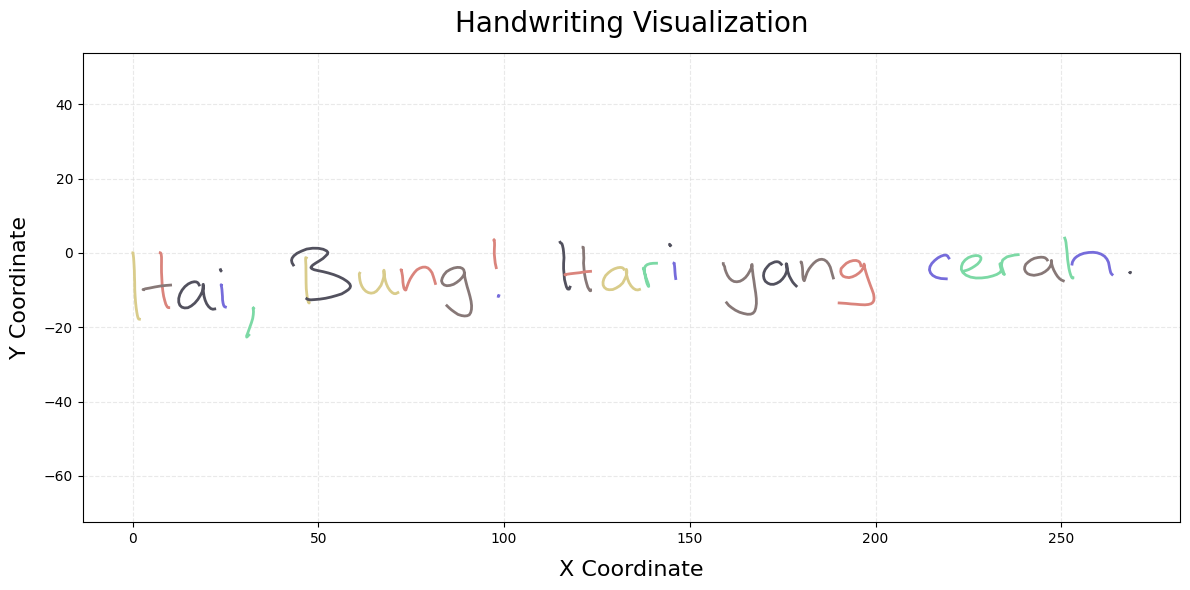


--- Sample 2 | Bias : 2.0 | Text : Hai, Bung! Hari yang cerah. ---
Length of generated sequence: 847  | EOS: True


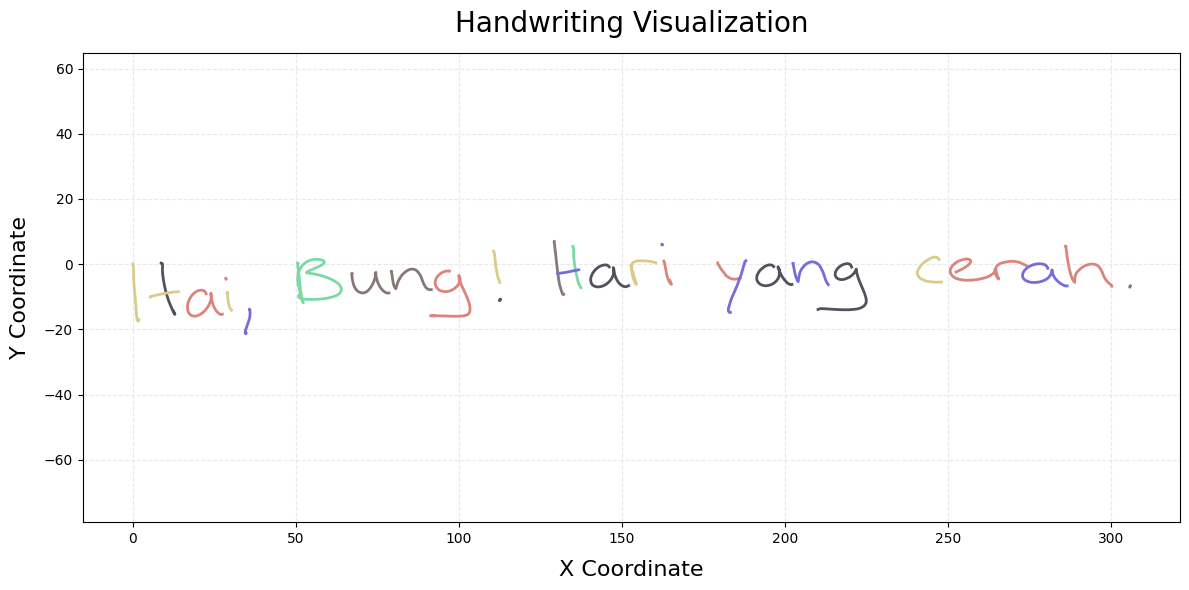


--- Sample 3 | Bias : 3.0 | Text : Hai, Bung! Hari yang cerah. ---
Length of generated sequence: 717  | EOS: True


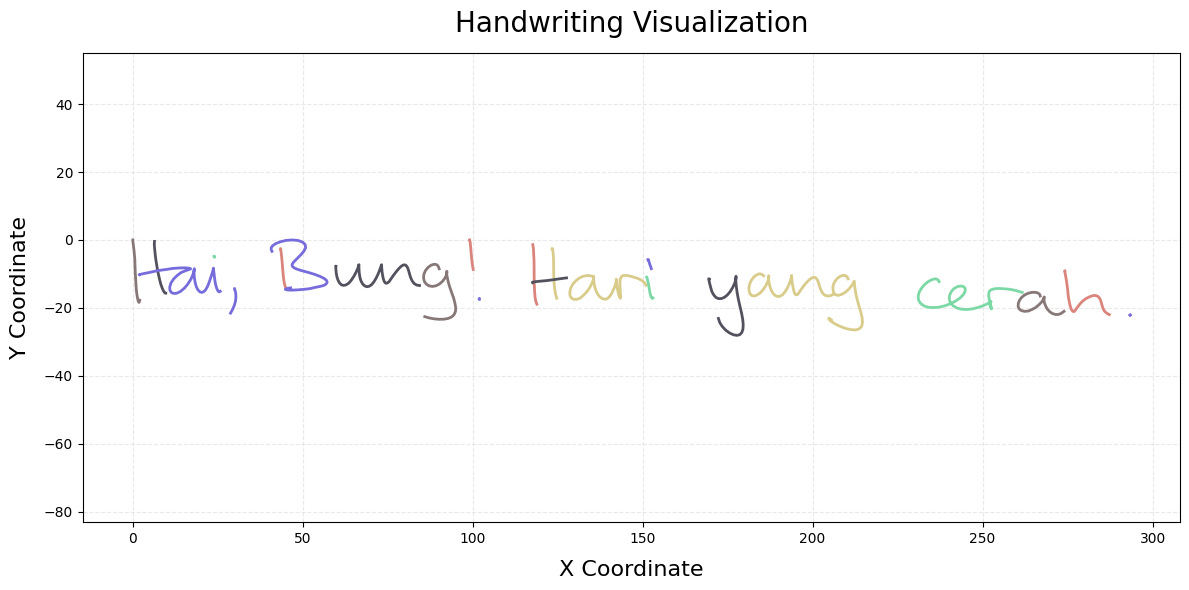


--- Sample 4 | Bias : 4.0 | Text : Hai, Bung! Hari yang cerah. ---
Length of generated sequence: 850  | EOS: True


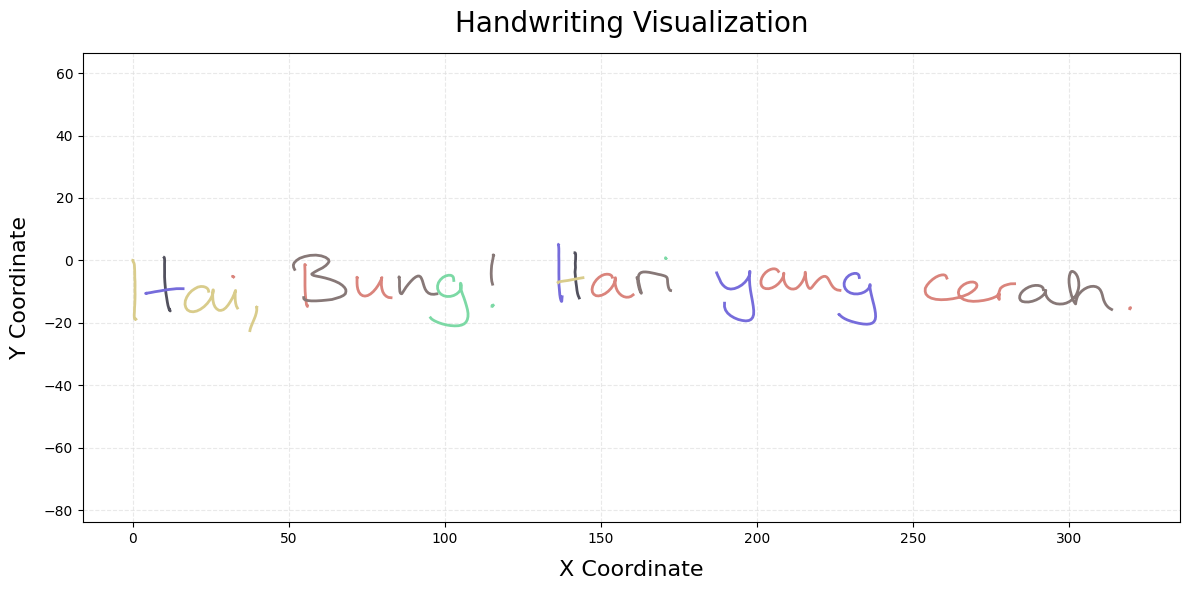


--- Sample 5 | Bias : 5.0 | Text : Hai, Bung! Hari yang cerah. ---
Length of generated sequence: 824  | EOS: True


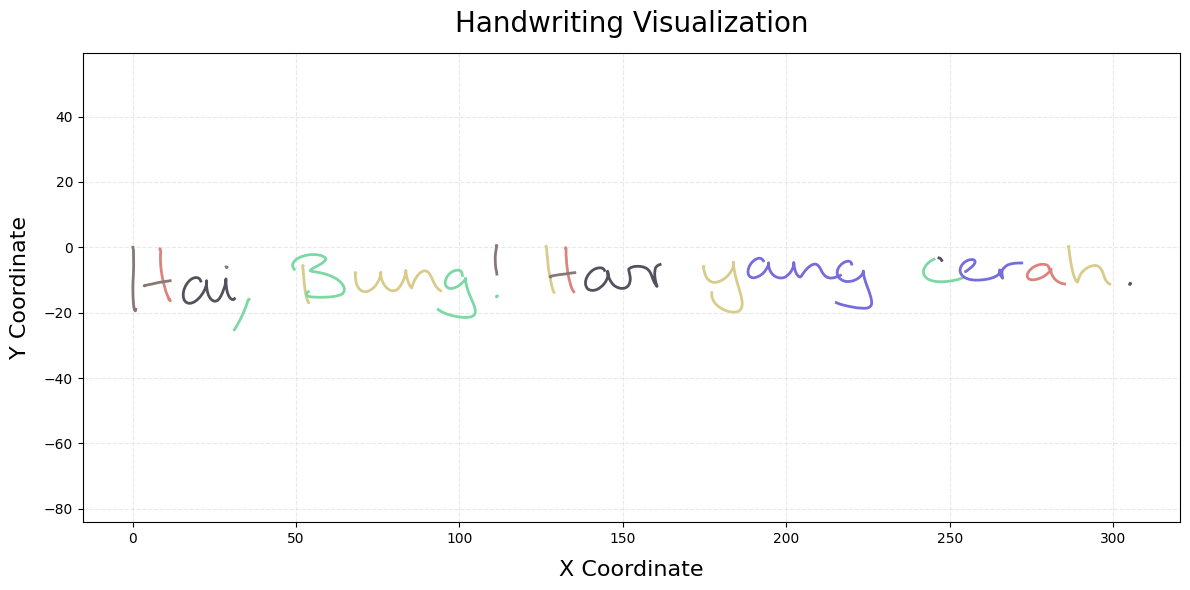

In [69]:
model_path = "../data/handwriting-model-100epoch.pt"
n = 5
test_bias = 1.0
test_text = "Hai, Bung! Hari yang cerah."

for i in range(n):
    print(f"\n--- Sample {i+1} | Bias : {test_bias} | Text : {test_text} ---")
    gen_seq = generate_sequence(model_path, test_text, bias=test_bias, prime=False, prime_seq=None, real_text=None)

    gen_seq = data_denormalization(Global.train_mean, Global.train_std, gen_seq)
    visualize_handwriting(delta_to_absolute(gen_seq[0]), invert_y=False)
    # visualize_handwriting_with_order(gen_seq[0], invert_y=False)
    test_bias = test_bias + 1.0